# Inverted pendulum: problem description
$
%%%%PREAMBLE%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Arrow notation
\newcommand{\ra}{\rightarrow}
\newcommand{\rra}{\rightrightarrows}
\newcommand{\la}{\leftarrow}
% \newcommand{\red}[1]{\textcolor{red}{#1}}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Abbreviations
\newcommand{\ie}{\unskip, i.\,e.,\xspace}
\newcommand{\eg}{\unskip, e.\,g.,\xspace}
\newcommand{\pd}{p.\,d.\xspace}
\newcommand{\sut}{\text{s.\,t.\,}}
\newcommand{\rt}{r.\,t.\xspace}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Wraps
\newcommand{\nrm}[1]{\left\lVert#1\right\rVert}
\newcommand{\diag}[1]{{\text{diag}}\left(#1\right)}
\newcommand{\abs}[1]{\left\lvert#1\right\rvert}
\newcommand{\scal}[1]{\left\langle#1\right\rangle}
\newcommand{\tr}[1]{{\text{tr}}\left(#1\right)}
\newcommand{\E}[1]{\mathbb E\left[#1\right]}
\newcommand{\PP}[1]{\mathbb P\left[#1\right]}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Set notation
\renewcommand{\N}{{\mathbb{N}}}
\renewcommand{\Z}{{\mathbb{Z}}}
\newcommand{\Q}{{\mathbb{Q}}}
\renewcommand{\R}{{\mathbb{R}}}
\newcommand{\T}{{\mathbb{T}}}
\newcommand{\X}{{\mathbb{X}}}
\newcommand{\Y}{{\mathbb{Y}}}
\newcommand{\F}{{\mathbb{F}}}
\newcommand{\U}{{\mathbb{U}}}
%\renewcommand{\U}{{\mathbb{U}}}
\newcommand{\sm}{{\setminus}}
\renewcommand{\set}[1]{{\mathbb{#1}}}
% \let\oldemptyset\emptyset
% \let\emptyset\varnothing
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Colored
% \newcommand{\red}[1]{\textcolor{red}{#1}}
% \newcommand{\blue}[1]{\textcolor{blue}{#1}}
% \definecolor{dgreen}{rgb}{0.0, 0.5, 0.0}
% \newcommand{\green}[1]{\textcolor{dgreen}{#1}}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Miscellaneous commands
\newcommand{\diff}{\mathop{}\!\mathrm{d}}
\newcommand{\eps}{{\varepsilon}}
\newcommand{\sgn}{{\text{sgn}}}
\newcommand{\spc}{{\,\,}}
\newcommand{\diam}{{\text{diam}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\ramp}{{\text{ramp}}}
\newcommand{\pdiff}[2]{ { \frac{\partial {#1}}{\partial {#2}} } }
\newcommand{\ball}{{\mathcal B}}
% \newcommand\circled[1]{\tikz[baseline=(char.base)]{\node[shape=circle,draw,inner sep=1pt](char){#1};}}
\newcommand{\co}{{\overline{\text{co}}}}
% \newcommand{\argmin}{\arg\min}
% \newcommand{\argmax}{arg\,max}
\newcommand{\lineZ}{\overline{Z}}
\newcommand{\lineR}{\overline{R}}
\newcommand{\linez}{\overline{z}}
\newcommand{\EP}[2]{\mathbb E_{#1}\left[#2\right]}
$

Here we consider a learning control for upswinging the inverted pendulum described by:
$$
    \begin{aligned}
        & \dot{\vartheta} = \omega, \\
        & \dot{\omega} = \frac{g}{l_p} \sin(\vartheta) + \frac{u}{m l_p^2}.
    \end{aligned}
    \qquad u \in [u_{\min}, u_{\max}]
$$
where $m$ is pendulum mass, $l_p$ is the pendulum length.
We assume the starting position of the pendulum down at rest:
$$
    \begin{aligned}
        & \vartheta(0) = \pi, \\
        & \omega(0) = 0.
    \end{aligned}    
$$


The formal goal of control reads:
$$
    \vartheta \ra 0 \qquad \omega  \ra 0.
$$

We will try to achieve this using a stochastic control policy defined by a model $\rho^\theta(u|\vartheta, \omega)$ with weights $\theta$ conditioned on the current *state* $(\vartheta, \omega)$ while optimizing some running cost $r$ which we will diccuss later.
We will treat this $\rho^\theta$ as a probability distribution and will sample the controls (actions) $u$ from $\rho^\theta$
Where necessary, we will stress the randomness of actions by capital letters like $U$.

There are many traditional control methods to achieve the state goal, including those based on the model.
In this notebook, we will pursue a different route: we will learn from pure experience by repeatedly running the pendulum and adjusting the model weights $\theta$.

To assess the performance of our learned policy, we will penalize it by a running cost function as follows:

$$
r(\vartheta, \omega, u) = 10 \vartheta^2 + 3 \omega^2
$$

**Remark 1**

Note that during lectures $r$ was denoted as reward function.
In this notebook we denote $r$ as cost function. This changes almost nothing for us, because one can easily
transform any reward function $r$ to the cost function via putting $r := -r$ and vice versa.

**Remark 2**

In general $r(\cdot)$ can depend on $u$, but in our case we do not put cost on action $u$.
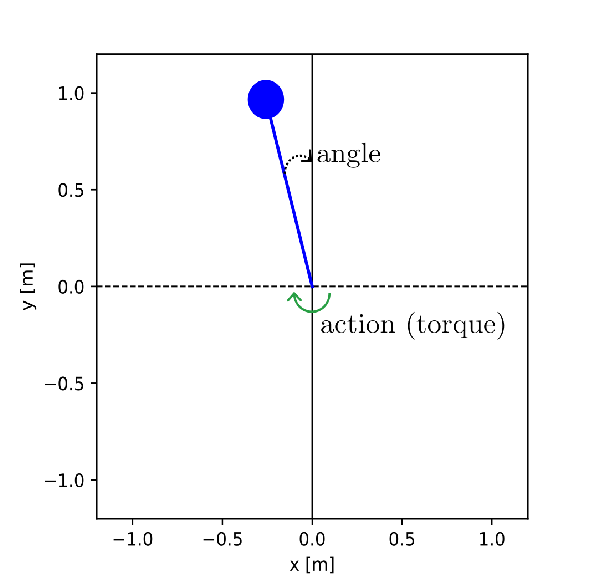

## Environment

Consider a system
$$
    X_{k + 1} \sim f(x_{k+1} \mid x_k, u_k), \quad Y_k = h(X_k), \quad U_{k} \sim \rho^{\theta}(u_{k} \mid y_k).
$$
We treat $x_k$ as a state (i.e. $(\vartheta, \omega)$ on step $k$) and $y_k$ as observation. If the observation function is trivial (an identity), we can just consider:
$$
    Y_{k+1} \sim f(y_{k+1} \mid y_k, u_k), \quad U_{k} \sim \rho^{\theta}(u_{k} \mid y_k).
$$
We will thus refer to $y$ as observation and state interchangeably since they are identical.

The goal is to solve the following optimal control problem
$$
    \min_{\theta} J(\theta) = \EP{f,\rho^\theta}{\sum_{k = 0}^{\infty} \gamma^k r(Y_k, U_k)}
$$
over policy weights $\theta$.
Here, $\gamma$ is the *discount factor*.

## Policy

The policy model will be taken as
$$
\rho^{\theta}(u \mid \vartheta, \omega) = \mathsf{pdf}_{\mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu^{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)
$$

where $ \mathsf{pdf}_{\mathcal{N}(\bullet_1, \bullet_2)} $ refers to the normal probability density with mean $\bullet_1$ and (co)variance $\bullet_2$, $\beta = \frac{u_{\min} + u_{\max}}{2}$, $\lambda = \frac{u_{\max} - u_{\min}}{2}$ and
the $\mu^{\theta}(\cdot)$ is a perceptron with weights $\theta$:
$$
    \mu^{\theta}(y) : y \ra \text{Linear(2, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 1)} \ra (1 - 3\sigma) \tanh\left(\frac{\cdot}{L}\right)
$$
##### Remarks
 - Hyperparameter $L$ is merely a tuning parameter and does not posess a physical meaning
 - Note that on every step generated action $U$ is a random variable that is distributed as $U \sim \lambda \mathcal{N}(\mu^{\theta}(y), \sigma^2) + \beta = \mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)$
 - The fact that $\mathsf{pdf}_{\mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu^{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)$ is true due to $\lambda \mathcal{N}(\mu^{\theta}(y), \sigma^2) + \beta = \mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)$
 - Note that $\frac{u - \beta}{\lambda} \in [-1, 1]$ for $u \in [u_{\min}, u_{\max}]$. By construction $\mu^{\theta}(y) \in [-1 + 3\sigma, 1 - 3\sigma]$. Thus, the policy $\rho^{\theta}(u \mid \vartheta, \omega)$ samples actions that are within action bounds $[u_{\min}, u_{\max}]$ with propability greater than 99.86% by $3\sigma$-[rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule). This slight imprecision has no effect on efficiency. See the picture below for details.



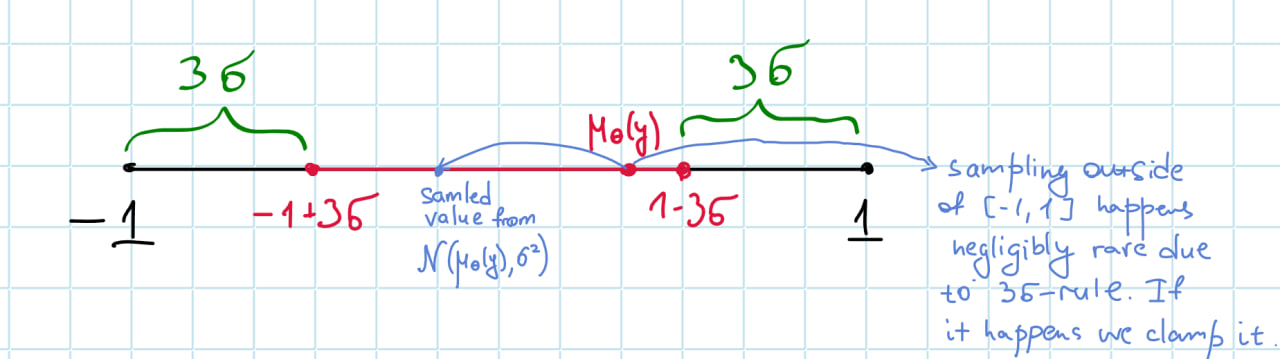

## Critic

In reinforcement learning algorithms critic is used for helping the policy (a.k.a. actor) to stabilize the system. This goal is achieved via running consequent optimization procedures for critic and policy. Thus, critic and policy are two entities that take turns in helping each other to achieve a common goal.

Critic model will be taken as perceptron $\hat{J}^{w}(y)$ with weights $w$ which approximates the so-called cost-to-go $J^{\rho^{\theta}}(y)$, i.e. the function that equals the expected value of discounted sum of infinite number costs with $y$ taken as intitial observation with further applying of the policy $\rho^{\theta}$ for infinite number of times. Strictly speaking,
$$
    \hat{J}^{w}(y) \approx J^{\rho^{\theta}}(y) = \E{\sum_{k = 0}^{\infty} \gamma ^ k r(Y_k, U_k) \mid Y_0 = y},
$$
where $\gamma \in [0,1]$ is a *discount factor* and should be interpreted as hyperparameter of algorithm.

## Actor-Critic Policy Gradient algorithm

General formula (you can find inference below implementation):

$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1} \la \theta_{i} - \alpha_i \E{  \sum_{k = 0}^{\infty} \gamma ^ k (r(Y_k, U_k) + \gamma J^{\rho^{\theta}}(Y_{k + 1}) - J^{\rho^{\theta}}(Y_{k})) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)\big|_{\theta=\theta^i}}
    \\
    \hphantom{~}
    \end{array}
  }.
$$

On practice the number of steps $k$ is finite and we denote it by $N$. The detailed description of algorithm is as follows (note that it works only for $\gamma < 1$).
> **for** $i$ in $\{1, \dots, \mathcal I\}$: ($\mathcal I$ is the number of iterations (alternatively, you can use a stopping criterion).
Every iteration consists of $M$ episodes, i.e., Monte-Carlo runs)
>>**for** $j$ in $\{1, \dots, M\}$: ($j$ is the number of episode, i.e., the number of a Monte-Carlo run)
>>>
>>> **for** $k$ in $\{0, \dots, N-1\}$: ($k$ is the number of step inside an episode)
>>>>
>>>> - obtain observation $y_k^j$ from the system
>>>> - sample action $u_k^j$ from $\rho^{\theta}(u_k^j \mid y_k^j)$
>
> Now we need to fit cost-to-go $\hat{J}^{w}$. We can do it by minimizing temporal difference loss with learning rate $\eta$ (note that $N_{\text{TD}}$, $N_{\text{epochs}}^{\text{Critic}}$ are also hyperparameters of algorithm). The optimization procedure converges only for $\gamma < 1$ (the optimization procedure that converges for $\gamma = 1$ is described [here](#miscellaneousremarks)):
>
> **for** $e$ in $\{1, ..., N_{\text{epochs}}^{\text{Critic}} \}$:
>>**for** $j$ in $\{1, \dots, M\}$:
>
>>> $
    w^{new} \la w^{old} -  \eta \nabla_{w}\left[\frac{\sum\limits_{k = 0}^{N-1-N_{\text{TD}}} \left(\hat{J}^{w}\left(y^j_k\right) - r\left(y^j_k, u_k^j\right) - \gamma r\left(y^j_{k+1}, u_{k+1}^j\right)- ... - \gamma^{N_{\text{TD}}-1} r\left(y^j_{k + N_{\text{TD}}-1}, u^j_{k + N_{\text{TD}}-1}\right) - \gamma^{N_{\text{TD}}} \hat{J}^{w}\left(y^j_{k + N_{\text{TD}}}\right)\right) ^ 2}{N-1-N_{\text{TD}}}\right]\bigg|_{w = w^{old}}
$
>
> Perform a policy gradient step:
>
> $
    \theta_{i+1}
    \la
    \theta_i
    -
    \alpha_i
    \frac{1}{M}
    \sum\limits_{j=1}^{M}
    \sum\limits_{k=0}^{N-2}
        \gamma^k \left( r(y^j_k, u^j_k) + \gamma \hat{J}^{w}(y^j_{k + 1}) - \hat{J}^{w}(y^j_k)\right)
        \nabla_\theta \ln\rho^\theta(u_k^j \mid y_k^j)\big|_{\theta=\theta^i}
$

**Remarks**.

- You can use a constant learning rate $\alpha$ throughout all the iterations, which should guarantee convergence in mean to a so called *noise ball* around a (local) optimizer, or use a *learning rate scheduler*, e.g., $\alpha_{i+1} \la \frac{\alpha}{\sqrt{i^2+1}}$ to achieve asymptotic convergence in mean.
In practice, too strong scheduler may fade away learning too much.
You can use some sophisticated scheduling in which you first do learning with a constant learning rate and then turn on the above scheduler.
- Simulation of the system can be done as $x_k^j \la x_{k-1}^j + \delta f(x_{k-1}^j, u_{k-1}^j)$ for $k \geq 1$, $\delta$ being the time step size and $x_0^j=$ `state_init`, where `state_init` = $\left(\pi, 0\right)$ in case of the inverted pendulum.


# Implementation

The code is organized as follows. The main loop is implemented in `MonteCarloSimulationScenario` which starts learning procedure via `run` method. The main loop is organized as presented in previous section. During the main loop all observations, actions, running costs for every episode and step are collected in `DataBuffer` object which is constructed in `Policy`. After every iteration `MonteCarloSimulationScenario` calls `self.critic.fit(self.data_buffer)` that fits the Value function. Then `self.policy.step(self.data_buffer)` method is called which does gradient descent step as described above via calling the `optimize` method that is implemented in `Optimizer`.

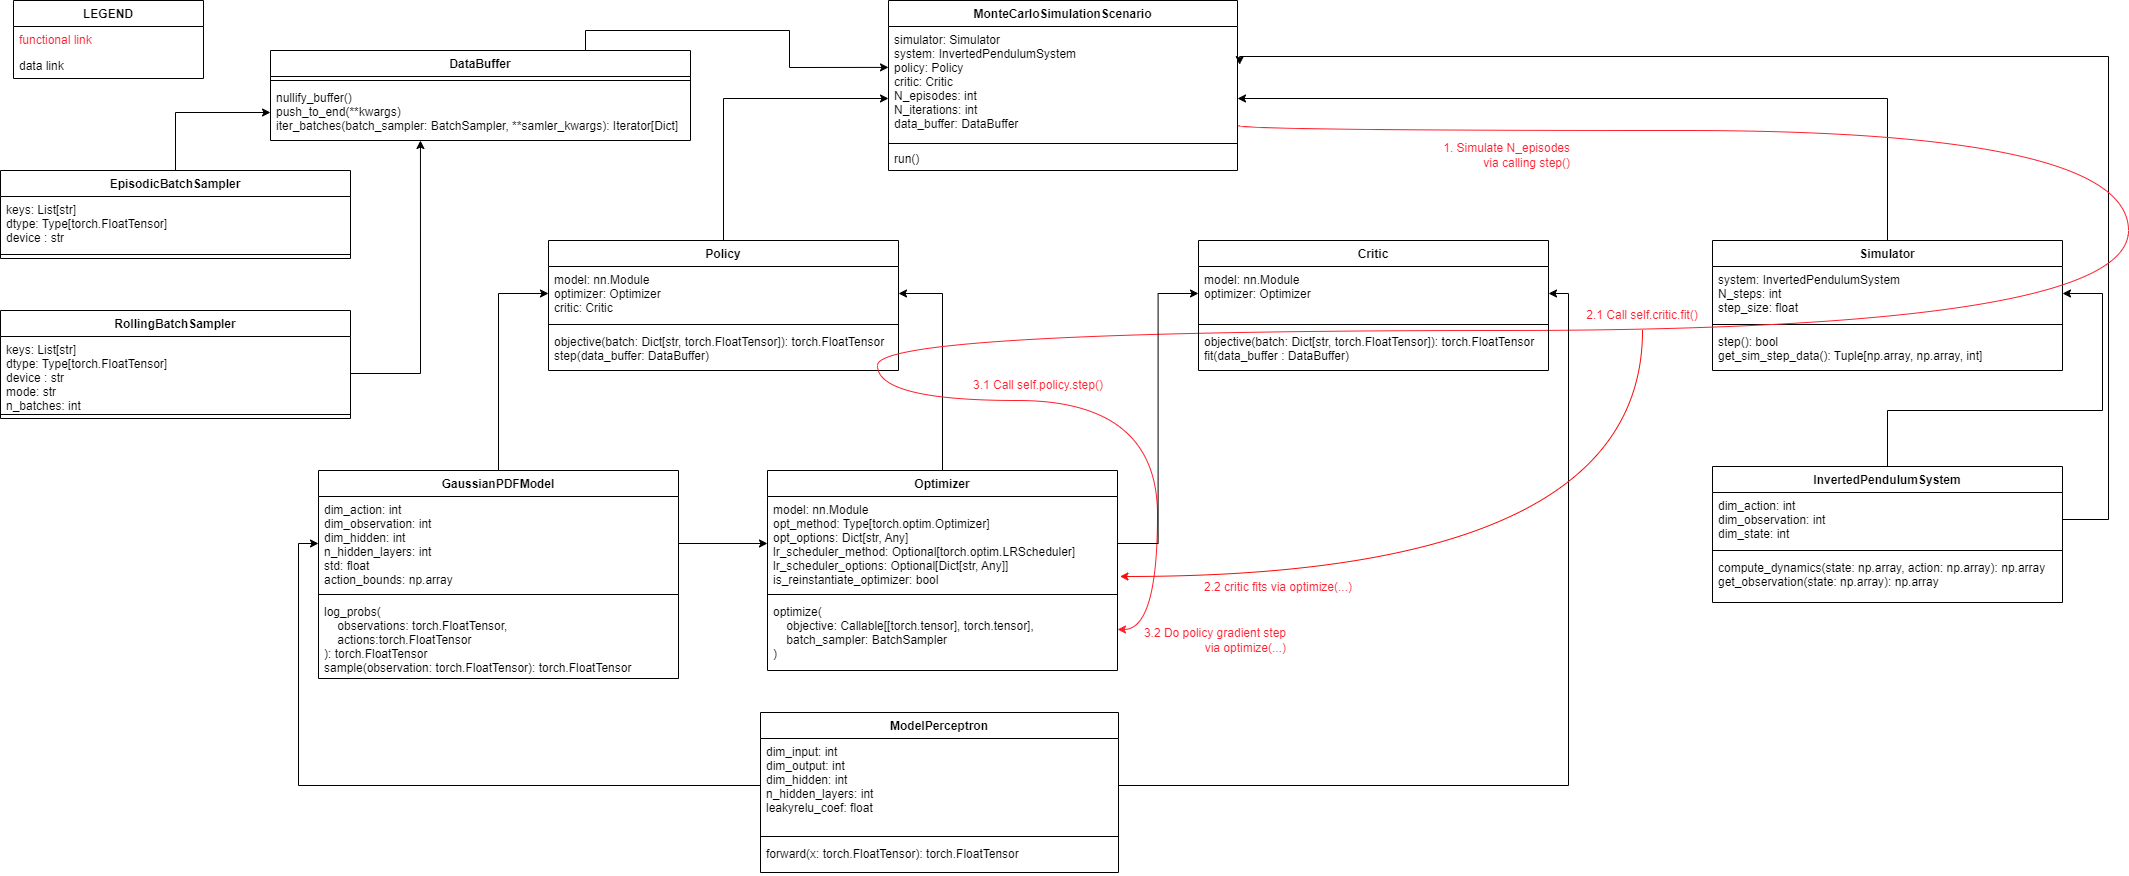


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import random
from tqdm import tqdm
from typing import Tuple, Dict, Optional, Callable, Type, Any
from IPython.display import clear_output

# Problem 1. Implement right hand side of Inverted pendulum system

$$
    \begin{aligned}
        & \dot{\vartheta} = \omega, \\
        & \dot{\omega} = \frac{g}{l_{p}} \sin(\vartheta) + \frac{u}{m l_p^2}.
    \end{aligned}
    \qquad u \in [u_{\min}, u_{\max}]
$$

In [2]:
class InvertedPendulumSystem:
    """System class: inverted pendulum. State transition function"""

    dim_action: int = 1
    dim_observation: int = 2
    dim_state: int = 2

    m: float = 0.5
    l: float = 0.5
    g: float = 9.81

    def __init__(self) -> None:
        """Initialize `InvertedPendulumSystem`"""

        self.reset()

    def reset(self) -> None:
        """Reset system to inital state."""

        self.action = np.zeros(self.dim_action)

    def compute_dynamics(self, state: np.array, action: np.array) -> np.array:
        """Calculate right-hand-side for Euler integrator

        Args:
            state (np.array): current state
            action (np.array): current action

        Returns:
            np.array: right-hand-side for Euler integrator
        """

        Dstate = np.zeros(self.dim_observation)

        # -----------------------------------------------------------------------
        # HINT
        # Assume that Dstate is the right-hand side of the system dynamics
        # description, and assign proper values to the components of Dstate,
        # assuming that:
        #
        # Dstate[0] is \dot{\vartheta}
        # Dstate[1] is \dot{\omega}

        # YOUR CODE GOES HERE
        Dstate[0] = state[1]
        Dstate[1] = self.g / self.l * np.sin(state[0]) + action[0] / (self.m * self.l**2)
        # -----------------------------------------------------------------------

        return Dstate

    def compute_closed_loop_rhs(self, state: np.array) -> np.array:
        """Get right-hand-side for current observation and saved `self.action`

        Args:
            state (np.array): current state

        Returns:
            np.array: right-hand-side for Euler integrator
        """

        system_right_hand_side = self.compute_dynamics(state, self.action)
        return system_right_hand_side

    def receive_action(self, action: np.array) -> None:
        """Save current action to `self.action`

        Args:
            action (np.array): current action
        """

        self.action = action

    @staticmethod
    def get_observation(state: np.array) -> np.array:
        """Get observation given a state

        Args:
            state (np.array): system state

        Returns:
            np.array: observation
        """
        observation = state

        return observation

## Simulator

Here we implement the Euler numerical integration scheme for our system.

In [3]:
class Simulator:
    """Euler integrator"""

    def __init__(
        self,
        system: InvertedPendulumSystem,
        N_steps: int,
        step_size: float,
        state_init: np.array,
    ):
        self.system = system
        self.N_steps = N_steps
        self.step_size = step_size
        self.state = np.copy(state_init)
        self.state_init = np.copy(state_init)
        self.current_step_idx = 0

    def step(self) -> bool:
        """Do one Euler integration step

        Returns:
            bool: status of simulation. `True` - simulation continues, `False` - simulation stopped
        """

        if self.current_step_idx <= self.N_steps:
            self.state += (
                self.system.compute_closed_loop_rhs(self.state) * self.step_size
            )
            self.current_step_idx += 1
            return True
        else:
            return False

    def reset(self) -> None:
        """Resets the system to initial state"""

        self.state = np.copy(self.state_init)
        self.current_step_idx = 0
        self.system.reset()

    def get_sim_step_data(self) -> Tuple[np.array, np.array, int]:
        """Get current observation, action and step id

        Returns:
            Tuple[np.array, np.array, int]:
        """

        return (
            self.system.get_observation(self.state),
            np.copy(self.system.action),
            int(self.current_step_idx),
        )

# Problem 1.2. Test your results

You have implemented the Inverted pendulum system. **Verify** that you have
done everything right. Compare your results with picture below. It should look exactly the same!

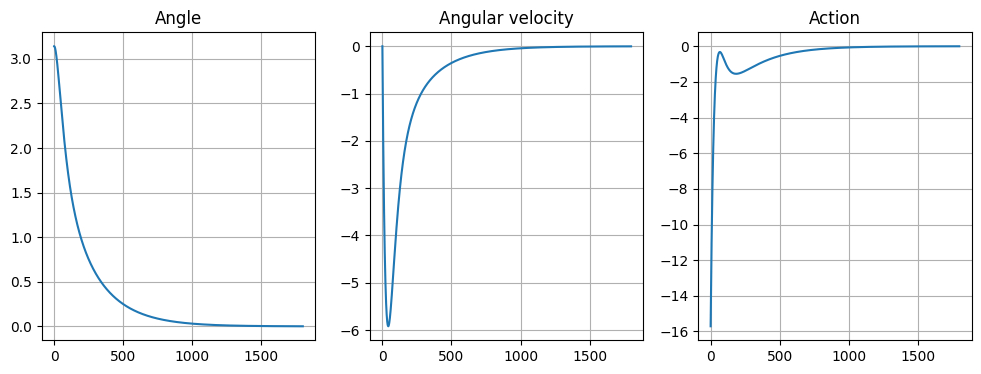

Text(0.5, 1.0, 'Action')

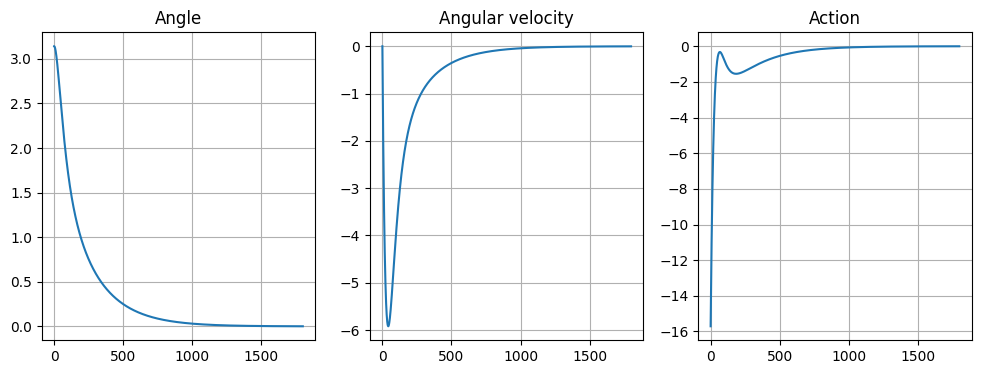

In [4]:
# RUN THIS!
system = InvertedPendulumSystem()
simulator = Simulator(
    system, N_steps=1800, step_size=0.003, state_init=np.array([np.pi, 0.0])
)
simulator.reset()

observations = []
actions = []
while simulator.step():
    (
        observation,
        action,
        step_idx,
    ) = simulator.get_sim_step_data()

    new_action = np.array([-5 * observation[0] + -2 * observation[1]])

    system.receive_action(new_action)
    observations.append(np.copy(observation))
    actions.append(np.copy(new_action))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(12, 4)
ax1.plot(np.array(observations)[:, 0])
ax1.grid()
ax1.set_title("Angle")
ax2.plot(np.array(observations)[:, 1])
ax2.grid()
ax2.set_title("Angular velocity")
ax3.plot(np.array(actions)[:, 0])
ax3.grid()
ax3.set_title("Action")

## Experience replay

We need to save all our observations and actions for gradient descent step.

For this purpose, we implement `class DataBuffer`. The functionality for sampling from it is also provided. There is no need to understand the code. We provide the interface for `DataBuffer` [below](#databufferinterface). There is no need to understand the interface too. We provide the explanation here only to satisfy your curiosity.

In [5]:
from abc import ABC, abstractmethod
from typing import Optional, List, Dict, Union, Iterable
from collections import defaultdict
import numpy as np
from typing import Union, Type


class FifoList(list):
    """Fifo list class. Acts like list but when size exceeds max_size it removes the first element."""

    def __init__(self, *args, max_size: Optional[int] = None, **kwargs):
        """Instantiate a FifoList.

        :param max_size: maximum size of the list. If `None` the list is not limited in size, defaults to None
        :type max_size: Optional[int], optional
        """
        super().__init__(*args, **kwargs)
        self.max_size = max_size

    def append(self, item: Any) -> None:
        super().append(item)
        if self.max_size is not None:
            if len(self) > self.max_size:
                self.pop(0)


RgArrayType = Union[
    Type[np.array],
    Type[torch.Tensor],
    Type[torch.FloatTensor],
    Type[torch.DoubleTensor],
    Type[torch.LongTensor],
]

RgArray = Union[
    FifoList,
    np.array,
    torch.Tensor,
    torch.FloatTensor,
    torch.DoubleTensor,
    torch.LongTensor,
]

import numpy as np
import torch


from typing import Any, Optional


class BatchSampler(ABC):
    """Base class for batch samplers."""

    def __init__(
        self,
        data_buffer,
        keys: Optional[List[str]],
        dtype: RgArrayType = torch.FloatTensor,
        device: Optional[Union[str, torch.device]] = None,
        fill_na: Optional[float] = 0.0,
    ):
        """Instantiate a BatchSampler.

        :param data_buffer: Data Buffer instance
        :type data_buffer: DataBuffer
        :param keys: keys to sample
        :type keys: Optional[List[str]]
        :param dtype: dtype for sample, can be either cs.DM, np.array, torch.Tensor, defaults to torch.FloatTensor
        :type dtype: RgArrayType, optional
        :param device: device for sampling, needed for torch.FloatTensor defaults to None
        :type device: Optional[Union[str, torch.device]], optional
        :param fill_na: fill value for np.nan, defaults to 0.0
        :type fill_na: Optional[float], optional, defaults to 0.0
        """
        self.keys = keys
        self.dtype = dtype
        self.data_buffer = data_buffer
        self.data_buffer.set_indexing_rules(
            keys=self.keys, dtype=self.dtype, device=device, fill_na=fill_na
        )
        self.len_data_buffer = len(self.data_buffer.data[self.keys[0]])
        self.device = device
        for k in self.keys:
            assert self.len_data_buffer == len(
                self.data_buffer.data[k]
            ), "All keys should have the same length in Data Buffer"

    def __iter__(self):
        if self.stop_iteration_criterion():
            self.nullify_sampler()
        return self

    def __next__(self):
        if self.stop_iteration_criterion():
            raise StopIteration
        return self.next()

    @abstractmethod
    def next(self) -> Dict[str, RgArray]:
        pass

    @abstractmethod
    def nullify_sampler(self) -> None:
        pass

    @abstractmethod
    def stop_iteration_criterion(self) -> bool:
        pass


class RollingBatchSampler(BatchSampler):
    """Batch sampler for rolling batches."""

    def __init__(
        self,
        mode: str,
        data_buffer,
        keys: Optional[List[str]],
        batch_size: Optional[int] = None,
        n_batches: Optional[int] = None,
        dtype: RgArrayType = torch.FloatTensor,
        device: Optional[Union[str, torch.device]] = None,
        fill_na: Optional[float] = 0.0,
    ):
        """Instantiate a RollingBatchSampler.

        :param mode: mode for batch sampling. Can be either 'uniform', 'backward', 'forward', 'full'. 'forward' for sampling of rolling batches from the beginning of DataBuffer. 'backward' for sampling of rolling batches from the end of DataBuffer. 'uniform' for sampling random uniformly batches. 'full' for sampling the full DataBuffer
        :type mode: str
        :param data_buffer: DataBuffer instance
        :type data_buffer: DataBuffer
        :param keys: DataBuffer keys for sampling
        :type keys: Optional[List[str]]
        :param batch_size: batch size, needed for 'uniform', 'backward', 'forward', defaults to None
        :type batch_size: Optional[int], optional
        :param n_batches: how many batches to sample, can be used for all modes. Note that sampling procedure stops in case if DataBuffer is exhausted for 'forward' and 'backward' modes,  defaults to None
        :type n_batches: Optional[int], optional
        :param dtype: dtype for sampling, can be either of cs.DM, np.array, torch.Tensor, defaults to torch.FloatTensor
        :type dtype: RgArrayType, optional
        :param device: device to sample from, defaults to None
        :type device: Optional[Union[str, torch.device]], optional
        :param fill_na: fill value for np.nan, defaults to 0.0
        :type fill_na: Optional[float], optional
        """
        if batch_size is None and mode in ["uniform", "backward", "forward"]:
            raise ValueError(
                "batch_size should not be None for modes ['uniform', 'backward', 'forward']"
            )
        assert mode in [
            "uniform",
            "backward",
            "forward",
            "full",
        ], "mode should be one of ['uniform', 'backward', 'forward', 'full']"
        assert not (
            n_batches is None and (mode == "uniform" or mode == "full")
        ), "'uniform' and 'full' mode are not avaliable for n_batches == None"

        BatchSampler.__init__(
            self,
            data_buffer=data_buffer,
            keys=keys,
            dtype=dtype,
            device=device,
            fill_na=fill_na,
        )
        self.mode = mode
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.n_batches_sampled: int
        self.nullify_sampler()

    def nullify_sampler(self) -> None:
        self.n_batches_sampled = 0
        if self.mode == "forward":
            self.batch_ids = np.arange(self.batch_size, dtype=int)
        elif self.mode == "backward":
            self.batch_ids = np.arange(
                self.len_data_buffer - self.batch_size,
                self.len_data_buffer,
                dtype=int,
            )
        elif self.mode == "uniform":
            self.batch_ids = np.random.randint(
                low=0,
                high=max(self.len_data_buffer - self.batch_size, 1),
            ) + np.arange(self.batch_size, dtype=int)
        elif self.mode == "full":
            self.batch_ids = np.arange(self.len_data_buffer, dtype=int)
        else:
            raise ValueError("mode should be one of ['uniform', 'backward', 'forward']")

    def stop_iteration_criterion(self) -> bool:
        if self.mode != "full":
            if self.len_data_buffer <= self.batch_size:
                return True
        if self.mode == "forward":
            return (
                self.batch_ids[-1] >= len(self.data_buffer)
                or self.n_batches == self.n_batches_sampled
            )
        elif self.mode == "backward":
            return self.batch_ids[0] <= 0 or self.n_batches == self.n_batches_sampled
        elif self.mode == "uniform" or self.mode == "full":
            return self.n_batches == self.n_batches_sampled
        else:
            raise ValueError(
                "mode should be one of ['uniform', 'backward', 'forward', 'full']"
            )

    def next(self) -> Dict[str, RgArray]:
        batch = self.data_buffer[self.batch_ids]
        if self.mode == "forward":
            self.batch_ids += 1
        elif self.mode == "backward":
            self.batch_ids -= 1
        elif self.mode == "uniform":
            self.batch_ids = np.random.randint(
                low=0, high=self.len_data_buffer - self.batch_size
            ) + np.arange(self.batch_size, dtype=int)

        # for self.mode == "full" we should not update batch_ids as they are constant for full mode
        # i. e. self.batch_ids == np.arange(self.len_data_buffer, dtype=int)

        self.n_batches_sampled += 1
        return batch


class EpisodicSampler(BatchSampler):
    """Samples the whole episodes from DataBuffer."""

    def __init__(
        self,
        data_buffer,
        keys: List[str],
        dtype: RgArrayType = torch.FloatTensor,
        device: Optional[Union[str, torch.device]] = None,
        fill_na: Optional[float] = 0.0,
    ):
        """Instantiate a EpisodicSampler.

        :param data_buffer: instance of DataBuffer
        :type data_buffer: DataBuffer
        :param keys: keys for sampling
        :type keys: List[str]
        :param dtype: batch dtype for sampling, can be either of cs.DM, np.array, torch.Tensor, defaults to torch.FloatTensor
        :type dtype: RgArrayType, optional
        :param device: torch.Tensor device for sampling, defaults to None
        :type device: Optional[Union[str, torch.device]], optional
        :param fill_na: fill value for np.nan, defaults to 0.0
        :type fill_na: Optional[float], optional
        """
        BatchSampler.__init__(
            self,
            data_buffer=data_buffer,
            keys=keys,
            dtype=dtype,
            device=device,
            fill_na=fill_na,
        )
        self.nullify_sampler()

    def nullify_sampler(self) -> None:
        self.episode_ids = (
            self.data_buffer.to_pandas(keys=["episode_id"])
            .astype(int)
            .values.reshape(-1)
        )
        self.max_episode_id = max(self.episode_ids)
        self.cur_episode_id = min(self.episode_ids) - 1
        self.idx_batch = -1

    def stop_iteration_criterion(self) -> bool:
        return self.cur_episode_id >= self.max_episode_id

    def get_episode_batch_ids(self, episode_id) -> np.array:
        return np.arange(len(self.data_buffer), dtype=int)[
            self.episode_ids == episode_id
        ]

    def next(self) -> Dict[str, RgArray]:
        self.cur_episode_id += 1
        batch_ids = self.get_episode_batch_ids(self.cur_episode_id)
        return self.data_buffer[batch_ids]


class DataBuffer:
    """DataBuffer class for storing run data.

    DataBuffer is a container for storing run data: observations, actions,
    running costs, iteration ids, episode ids, step ids. It is designed to store any
    data of numeric format.
    """

    def __init__(
        self,
        max_buffer_size: Optional[int] = None,
    ):
        """Instantiate a DataBuffer.

        :param max_buffer_size: maximum size of the buffer. If None the DataBuffer is not limited in size, defaults to None
        :type max_buffer_size: Optional[int], optional
        """
        self.max_buffer_size = max_buffer_size
        self.nullify_buffer()

    def delete_key(self, key) -> None:
        self.data.pop(key)

    def keys(self) -> List[str]:
        return list(self.data.keys())

    def nullify_buffer(self) -> None:
        self.data = defaultdict(lambda: FifoList(max_size=self.max_buffer_size))
        self.keys_for_indexing = None
        self.dtype_for_indexing = None
        self.device_for_indexing = None
        self.fill_na_for_indexing = None

    def update(self, data_in_dict_format: dict[str, RgArray]) -> None:
        for key, data_for_key in data_in_dict_format.items():
            self.data[key] = data_for_key

    def push_to_end(self, **kwargs) -> None:
        current_keys = set(self.data.keys())
        kwarg_keys = set(kwargs.keys())

        for _, data_item_for_key in kwargs.items():
            if np.any(np.isnan(data_item_for_key)):
                raise ValueError(
                    f"{type(data_item_for_key)} nan values are not allowed for `push_to_end` in data buffer"
                )
        is_line_added = False
        for key in current_keys.intersection(kwarg_keys):
            datum = np.array(kwargs[key])
            if np.any(np.isnan(self.data[key][-1])):
                self.data[key][-1] = datum
            else:
                self.data[key].append(datum)
                is_line_added = True

        buffer_len = len(self)
        for key in kwarg_keys.difference(current_keys):
            datum = np.array(kwargs[key])
            for _ in range(buffer_len - 1):
                self.data[key].append(np.full_like(datum, np.nan, dtype=float))
            self.data[key].append(datum)

        # if buffer len has changed fill all the rest keys with nan
        if is_line_added:
            for key in current_keys.difference(kwarg_keys):
                self.data[key].append(
                    np.full_like(self.data[key][-1], np.nan, dtype=float)
                )

    def last(self) -> dict[str, RgArray]:
        return self[-1]

    def to_dict(self):
        return self.data

    def to_pandas(self, keys: Optional[List[str]] = None) -> pd.DataFrame:
        if keys is not None:
            return pd.DataFrame({k: self.data[k] for k in keys})

        return pd.DataFrame(self.data)

    def __len__(self):
        if len(self.data.keys()) == 0:
            return 0
        else:
            return max([len(self.data[k]) for k in self.data.keys()])

    def _fill_na(self, arr: np.array, fill_na: Optional[float] = None) -> np.array:
        if fill_na is None:
            return arr
        else:
            np.nan_to_num(arr, copy=False, nan=fill_na)
            return arr

    def getitem(
        self,
        idx: Union[int, slice, Any],
        keys: Optional[Union[List[str], np.array]] = None,
        dtype: RgArrayType = np.array,
        device: Optional[Union[str, torch.device]] = None,
        fill_na: Optional[float] = 0.0,
    ) -> dict[str, RgArray]:
        _keys = keys if keys is not None else self.data.keys()
        if (
            isinstance(idx, int)
            or isinstance(idx, slice)
            or isinstance(idx, np.ndarray)
        ):
            if dtype == np.array:
                return {
                    key: self._fill_na(np.vstack(self.data[key])[idx], fill_na=fill_na)
                    for key in _keys
                }
            elif (
                dtype == torch.tensor
                or dtype == torch.FloatTensor
                or dtype == torch.DoubleTensor
                or dtype == torch.LongTensor
            ):
                if device is not None:
                    return {
                        key: dtype(
                            self._fill_na(np.vstack(self.data[key]), fill_na=fill_na)
                        )[idx].to(device)
                        for key in _keys
                    }
                else:
                    return {
                        key: dtype(
                            self._fill_na(np.vstack(self.data[key]), fill_na=fill_na)
                        )[idx]
                        for key in _keys
                    }
            else:
                raise ValueError(f"Unexpeted dtype in data_buffer.getitem: {dtype}")

    def set_indexing_rules(
        self,
        keys: List[str],
        dtype: RgArrayType,
        device: Optional[Union[str, torch.device]] = None,
        fill_na: Optional[float] = 0.0,
    ) -> None:
        self.keys_for_indexing = keys
        self.dtype_for_indexing = dtype
        self.device_for_indexing = device
        self.fill_na_for_indexing = fill_na

    def __getitem__(self, idx) -> dict[str, RgArray]:
        return self.getitem(
            idx,
            keys=self.keys_for_indexing,
            dtype=self.dtype_for_indexing,
            device=self.device_for_indexing,
            fill_na=self.fill_na_for_indexing,
        )

    def iter_batches(
        self,
        keys: List[str],
        batch_sampler: Type[BatchSampler] = RollingBatchSampler,
        **batch_sampler_kwargs,
    ) -> Iterable[RgArray]:
        return batch_sampler(data_buffer=self, keys=keys, **batch_sampler_kwargs)

<a name="databufferinterface"></a>
### DataBuffer interface

In [6]:
data_buffer = DataBuffer()

for i in range(6):
    data_buffer.push_to_end(
        key1=i**2,
        key2=[i, i],
        key3=[i**3, 0],
        episode_id=i // 2,
    )

# Demonstrating the content of DataBuffer
data_buffer.to_pandas()

,episode_id,key2,key1,key3
0,0,"[0, 0]",0,"[0, 0]"
1,0,"[1, 1]",1,"[1, 0]"
2,1,"[2, 2]",4,"[8, 0]"
3,1,"[3, 3]",9,"[27, 0]"
4,2,"[4, 4]",16,"[64, 0]"
5,2,"[5, 5]",25,"[125, 0]"


In [7]:
import pprint

sampler = data_buffer.iter_batches(
    batch_sampler=RollingBatchSampler, keys=["key1", "key2"], mode="full", n_batches=2
)

# Let us write the loop to iterate over the batches. Every batch contains all the data for one episode
i = 1
for batch in sampler:
    print("--------\n", i, "batch")
    pprint.pprint(batch)
    i += 1

--------
 1 batch
{'key1': tensor([[ 0.],
        [ 1.],
        [ 4.],
        [ 9.],
        [16.],
        [25.]]),
 'key2': tensor([[0., 0.],
        [1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.]])}
--------
 2 batch
{'key1': tensor([[ 0.],
        [ 1.],
        [ 4.],
        [ 9.],
        [16.],
        [25.]]),
 'key2': tensor([[0., 0.],
        [1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.]])}


In [8]:
import pprint

sampler = data_buffer.iter_batches(
    batch_sampler=EpisodicSampler,
    keys=["episode_id", "key1"],
)

# Let us write the loop to iterate over the batches. Every batch contains all the data for one episode
i = 1
for batch in sampler:
    print("--------\n", i, "batch")
    pprint.pprint(batch)
    i += 1

--------
 1 batch
{'episode_id': tensor([[0.],
        [0.]]),
 'key1': tensor([[0.],
        [1.]])}
--------
 2 batch
{'episode_id': tensor([[1.],
        [1.]]),
 'key1': tensor([[4.],
        [9.]])}
--------
 3 batch
{'episode_id': tensor([[2.],
        [2.]]),
 'key1': tensor([[16.],
        [25.]])}


# Utilities for Optimizer

In [9]:
class Optimizer:
    """Does gradient step for optimizing model weights"""

    def __init__(
        self,
        model: nn.Module,
        opt_method: Type[torch.optim.Optimizer],
        opt_options: Dict[str, Any],
        lr_scheduler_method: Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        lr_scheduler_options: Optional[Dict[str, Any]] = None,
        is_reinstantiate_optimizer: bool = False,
        n_epochs: int = 1,
    ):
        """Initialize Optimizer

        Args:
            model (nn.Module): model which weights we need to optimize
            opt_method (Type[torch.optim.Optimizer]): method type for optimization. For instance, `opt_method=torch.optim.SGD`
            opt_options (Dict[str, Any]): kwargs dict for opt method
            lr_scheduler_method (Optional[torch.optim.lr_scheduler.LRScheduler], optional): method type for LRScheduler. Defaults to None
            lr_scheduler_options (Optional[Dict[str, Any]], optional): kwargs for LRScheduler. Defaults to None
            is_reinstantiate_optimizer (bool, optional): whether to reinstantiate optimizer if optimize() method is called. Defaults to False
            n_epochs (int, optional): number of epochs. Defaults to 1
        """

        self.opt_method = opt_method
        self.opt_options = opt_options
        self.model = model
        self.optimizer = self.opt_method(self.model.parameters(), **self.opt_options)
        self.lr_scheduler_method = lr_scheduler_method
        self.lr_scheduler_options = lr_scheduler_options
        if self.lr_scheduler_method is not None:
            self.lr_scheduler = self.lr_scheduler_method(
                self.optimizer, **self.lr_scheduler_options
            )
        else:
            self.lr_scheduler = None

        self.is_reinstantiate_optimizer = is_reinstantiate_optimizer
        self.n_epochs = n_epochs

    def optimize(
        self,
        objective: Callable[[torch.tensor], torch.tensor],
        batch_sampler: BatchSampler,
    ) -> None:
        """Do gradient step.

        Args:
            objective (Callable[[torch.tensor], torch.tensor]): objective to optimize
            batch_sampler (BatchSampler): batch sampler that samples batches for gradient descent
        """

        if self.is_reinstantiate_optimizer:
            self.optimizer = self.opt_method(
                self.model.parameters(), **self.opt_options
            )

        history = []
        for _ in range(self.n_epochs):
            for batch_sample in batch_sampler:
                self.optimizer.zero_grad()
                objective_value = objective(batch_sample)
                objective_value.backward()
                self.optimizer.step()
            history.append(objective_value.item())

        return history

## Perceptron

We provide here the general perceptron model. The class is used in `class Policy` and in `class Critic`

In [10]:
class ModelPerceptron(nn.Module):
    def __init__(
        self,
        dim_input: int,
        dim_output: int,
        dim_hidden: int,
        n_hidden_layers: int,
        leaky_relu_coef: float = 0.15,
        is_bias: bool = True,
    ):
        """Instatiate ModelPerceptron

        :param dim_input: dimension of input layer
        :type dim_input: int
        :param dim_output: dimension of output layer
        :type dim_output: int
        :param dim_hidden: dimension of hidden layers
        :type dim_hidden: int
        :param n_hidden_layers: number of hidden layers
        :type n_hidden_layers: int
        :param leaky_relu_coef: coefficient for leaky_relu activation functions, defaults to 0.15
        :type leaky_relu_coef: float, optional
        :param is_bias: whether to use bias in linear layers, defaults to True
        :type is_bias: bool, optional
        """
        super().__init__()
        self.dim_input = dim_input
        self.dim_output = dim_output
        self.n_hidden_layers = n_hidden_layers
        self.leaky_relu_coef = leaky_relu_coef
        self.is_bias = is_bias

        self.input_layer = nn.Linear(dim_input, dim_hidden, bias=is_bias)
        self.hidden_layers = nn.ModuleList(
            [
                nn.Linear(dim_hidden, dim_hidden, bias=is_bias)
                for _ in range(n_hidden_layers)
            ]
        )
        self.output_layer = nn.Linear(dim_hidden, dim_output, bias=is_bias)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """Make forward pass through the perceptron

        :param x: input Float Tensor
        :type x: torch.FloatTensor
        :return: output of perceptron
        :rtype: torch.FloatTensor
        """
        x = nn.functional.leaky_relu(
            self.input_layer(x), negative_slope=self.leaky_relu_coef
        )
        for layer in self.hidden_layers:
            x = nn.functional.leaky_relu(layer(x), negative_slope=self.leaky_relu_coef)
        x = self.output_layer(x)
        return x

## Problem 2. Implementation of critic class

In this problem you need to implement temporal difference objective.

The method `def objective(batch)` should return
$$
\frac{1}{N-1-N_{\text{TD}}}\sum_{k = 0}^{N-1-N_{\text{TD}}} (\hat{J}^{w}(y_k) - r(y_k, u_k) - \gamma r(y_{k+1}, u_{k+1}) ... - \gamma^{N_{\text{TD}}-1} r(y_{k + N_{\text{TD}}-1}, u^j_{k + N_{\text{TD}}-1}) - \gamma^{N_{\text{TD}}} \hat{J}^{w}(y_{k + N_{\text{TD}}})) ^ 2
$$

Note that
1. $N_{\text{TD}}$ is `self.td_n`
2. $\hat{J}^{w}$ is `self.model`
3. We send into objective data that already represents exactly **full** episode. All infrastructure for sampling of the whole episodes is already written in `DataBuffer` section. The data in batch is organized as follows
$$
    \begin{matrix}
        \texttt{observations} & \texttt{running}\_\texttt{objectives}  \\
        y_0 &  r(y_0, u_0) \\
        y_1 &  r(y_1, u_1)  \\
        y_2 &  r(y_2, u_2) \\
        \vdots & \vdots \\
        y_{N-1} & r(y_{N-1}, u_{N-1})
    \end{matrix}
$$

In [11]:
class Critic:
    def __init__(
        self,
        td_n: int,
        discount_factor: float,
        device: str,
        model: nn.Module,
        optimizer: Optimizer,
    ):
        """Instantiate Critic

        :param td_n: number of terms in temporal difference objective
        :type td_n: int
        :param discount_factor: discount factor to use in temproal difference objective
        :type discount_factor: float
        :param device: device for model fitting
        :type device: str
        :param model: NN network that should fit the Value function
        :type model: nn.Module
        :param optimizer: optimizer for fitting of Value function
        :type optimizer: Optimizer
        """
        self.model = model
        self.td_n = td_n
        self.device = device
        self.discount_factor = discount_factor
        self.optimizer = optimizer

    def objective(self, batch: Dict[str, torch.FloatTensor]) -> torch.FloatTensor:
        """Calculate temporal difference objective

        :param batch: dict that contains episodic data: observations, running_costs
        :type batch: Dict[str, torch.FloatTensor]
        :return: temporal difference objective
        :rtype: torch.FloatTensor
        """

        observations = batch["observation"]
        running_costs = batch["running_cost"]

        # -----------------------------------------------------------------------
        # YOUR CODE GOES HERE
        objectives = self.model(observations)
        costs_dist = running_costs[:-1].unfold(0, self.td_n, 1) * self.discount_factor**torch.arange(0, self.td_n)
        objective = (objectives[:-self.td_n] - costs_dist.sum(dim=1) - objectives[self.td_n:] * self.discount_factor**self.td_n)**2
        return objective.mean()
        # -----------------------------------------------------------------------

    def fit(self, buffer: DataBuffer) -> None:
        """Runs optimization procedure for critic

        :param buffer: data buffer with experience replay
        :type buffer: DataBuffer
        """
        self.model.to(self.device)
        self.optimizer.optimize(
            self.objective,
            buffer.iter_batches(
                batch_sampler=EpisodicSampler,
                keys=[
                    "observation",
                    "observation_action",
                    "running_cost",
                ],
                device=self.device,
            ),
        )

## Problem 3. Policy Model


The policy model will be taken as:
$$
\rho^{\theta}(u \mid \vartheta, \omega) = \mathsf{pdf}_{\mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu^{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)
$$

where $ \mathsf{pdf}_{\mathcal{N}(\bullet_1, \bullet_2)} $ refers to the normal probability density with mean $\bullet_1$ and (co)variance $\bullet_2$, $\beta = \frac{u_{\min} + u_{\max}}{2}$, $\lambda = \frac{u_{\max} - u_{\min}}{2}$ and
the $\mu^{\theta}(\cdot)$ is a perceptron with weights $\theta$:
$$
    \mu^{\theta}(y) : y \ra \text{Linear(2, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 1)} \ra (1 - 3\sigma) \tanh\left(\frac{\cdot}{L}\right)
$$
##### Remarks
 - Hyperparameter $L$ is merely a tuning parameter and does not posess a physical meaning.
 - Note that on every step generated action $U$ is a random variable that is distributed as $U \sim \lambda \mathcal{N}(\mu^{\theta}(y), \sigma^2) + \beta = \mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)$
 - $\mathsf{pdf}_{\mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu^{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)$ due to $\lambda \mathcal{N}(\mu^{\theta}(y), \sigma^2) + \beta = \mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)$
 - Note that $\frac{u - \beta}{\lambda} \in [-1, 1]$ for $u \in [u_{\min}, u_{\max}]$. By construction $\mu^{\theta}(y) \in [-1 + 3\sigma, 1 - 3\sigma]$. Thus, the policy $\rho^{\theta}(u \mid \vartheta, \omega)$ samples actions that are within action bounds $[u_{\min}, u_{\max}]$ with propability greater than 99.86% by $3\sigma$-[rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule). This slight imprecision has no effect on efficiency.

The model is based on `torch`'s `nn.Module`.
Thus, sampling from $\mathcal{N}\left(\lambda\mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)$
can be done out of the box.

Also `torch`'s auto-differentiator can compute gradients of $\ln \, \mathsf{pdf}_{\mathcal{N}\left(\lambda\mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \ln \rho^{\theta}(u | \vartheta, \omega)$ which is handy.



In [12]:
class GaussianPDFModel(nn.Module):

    """Model that acts like f(x) + normally distributed noise"""

    def __init__(
        self,
        dim_observation: int,
        dim_action: int,
        dim_hidden: int,
        n_hidden_layers: int,
        std: float,
        action_bounds: np.array,
        scale_factor: float,
        leakyrelu_coef=0.2,
    ):
        """Initialize model.

        Args:
            dim_observation (int): dimensionality of observation
            dim_action (int): dimensionality of action
            dim_hidden (int): dimensionality of hidden layer of perceptron (dim_hidden = 4 works for our case)
            std (float): standard deviation of noise (\\sigma)
            action_bounds (np.array): action bounds with shape (dim_action, 2). `action_bounds[:, 0]` - minimal actions, `action_bounds[:, 1]` - maximal actions
            scale_factor (float): scale factor for last activation (L coefficient) (see details above)
            leakyrelu_coef (float): coefficient for leakyrelu
        """

        super().__init__()

        self.dim_observation = dim_observation
        self.dim_action = dim_action
        self.dim_hidden = dim_hidden
        self.std = std

        self.scale_factor = scale_factor
        self.register_parameter(
            name="scale_tril_matrix",
            param=torch.nn.Parameter(
                (self.std * torch.eye(self.dim_action)).float(),
                requires_grad=False,
            ),
        )
        self.register_parameter(
            name="action_bounds",
            param=torch.nn.Parameter(
                torch.tensor(action_bounds).float(),
                requires_grad=False,
            ),
        )

        self.perceptron = ModelPerceptron(
            dim_input=self.dim_observation,
            dim_output=self.dim_action,
            dim_hidden=dim_hidden,
            n_hidden_layers=n_hidden_layers,
            leaky_relu_coef=leakyrelu_coef,
        )

    def get_unscale_coefs_from_minus_one_one_to_action_bounds(
        self,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """Calculate coefficients for linear transformation from [-1, 1] to [u_min, u_max].

        Returns:
            Tuple[torch.FloatTensor, torch.FloatTensor]: coefficients
        """

        action_bounds = self.get_parameter("action_bounds")
        # -----------------------------------------------------------------------
        # HINT
        #
        # You need to return a tuple of \\beta, \\lambda
        #
        # Note that action bounds are denoted above as [u_min, u_max]
        #
        # YOUR CODE GOES HERE
        beta_ = action_bounds.mean(dim=1)
        lambda_ = action_bounds[:, 1] - beta_

        return beta_, lambda_
        # -----------------------------------------------------------------------

    def unscale_from_minus_one_one_to_action_bounds(
        self, x: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Linear transformation from [-1, 1] to [u_min, u_max].

        Args:
            x (torch.FloatTensor): tensor to transform

        Returns:
            torch.FloatTensor: transformed tensor
        """

        (
            unscale_bias,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        return x * unscale_multiplier + unscale_bias

    def scale_from_action_bounds_to_minus_one_one(
        self, y: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Linear transformation from [u_min, u_max] to [-1, 1].

        Args:
            y (torch.FloatTensor): tensor to transform

        Returns:
            torch.FloatTensor: transformed tensor
        """

        (
            unscale_bias,
            unscale_multiplier,
        ) = self.get_unscale_coefs_from_minus_one_one_to_action_bounds()

        return (y - unscale_bias) / unscale_multiplier

    def get_means(self, observations: torch.FloatTensor) -> torch.FloatTensor:
        """Return mean for MultivariateNormal from `observations`

        Args:
            observations (torch.FloatTensor): observations

        Returns:
            torch.FloatTensor: means
        """

        # -----------------------------------------------------------------------
        # HINT
        #
        # You should return here exactly the \\mu^theta(observations)
        # YOUR CODE GOES HERE
        out = self.perceptron(observations)
        return (1 - 3 * self.std) * torch.tanh(out / self.scale_factor)
        # -----------------------------------------------------------------------

    def log_probs(
        self, observations: torch.FloatTensor, actions: torch.FloatTensor
    ) -> torch.FloatTensor:
        """Get log pdf from the batch of observations actions

        Args:
            observations (torch.FloatTensor): batch of observations
            actions (torch.FloatTensor): batch of actions

        Returns:
            torch.FloatTensor: log pdf(action | observation) for the batch of observations and actions
        """

        scale_tril_matrix = self.get_parameter("scale_tril_matrix")

        # -----------------------------------------------------------------------
        # HINT
        # You should calculate pdf_Normal(\\lambda \\mu^theta(observations) + \\beta, \\lambda ** 2 \\sigma ** 2)(actions)
        #
        # TAs used not NormalDistribution, but MultivariateNormal
        # See here https://pytorch.org/docs/stable/distributions.html#multivariatenormal
        # YOUR CODE GOES HERE
        scaled_mean = self.get_means(observations)
        scaled_action = self.scale_from_action_bounds_to_minus_one_one(actions)
        log_probs = MultivariateNormal(scaled_mean, scale_tril=scale_tril_matrix).log_prob(scaled_action)
        return log_probs
        # -----------------------------------------------------------------------

    def sample(self, observation: torch.FloatTensor) -> torch.FloatTensor:
        """Sample action from `MultivariteNormal(lambda * self.get_means(observation) + beta, lambda ** 2 * Diag[self.std] ** 2)`

        Args:
            observation (torch.FloatTensor): current observation

        Returns:
            torch.FloatTensor: sampled action
        """
        action_bounds = self.get_parameter("action_bounds")
        scale_tril_matrix = self.get_parameter("scale_tril_matrix")

        # -----------------------------------------------------------------------
        # HINT
        # Sample action from `MultivariteNormal(lambda * self.get_means(observation) + beta, lambda ** 2 * Diag[self.std] ** 2)
        # YOUR CODE GOES HERE
        scaled_mean = self.get_means(observation)
        sampled_scaled_action = MultivariateNormal(scaled_mean, scale_tril=scale_tril_matrix).sample()
        sampled_action = self.unscale_from_minus_one_one_to_action_bounds(sampled_scaled_action)
        # -----------------------------------------------------------------------
        return torch.clamp(sampled_action, action_bounds[:, 0], action_bounds[:, 1])

## Problem 4. Policy

In this task you need to calculate **surrogate** objective value here
$$
 \frac{1}{M}
    \sum_{j=1}^{M}
    \sum_{k=0}^{N-2}
        \gamma^k \left(r(y_k^j, u_k^j) + \gamma \hat{J}^{w}(y_{k+1}^j) - \hat{J}^{w}(y_{k}^j)\right)
        \ln\rho^\theta(u_k^j \mid y_k^j)
$$

Note that we use the following notation in code

1. `N_episodes` is M
2. `observations_actions` is the batch of $(y_{k}^j, u_{k}^j)$ with shape ($M\times N$, `dim_observation` + `dim_action`).
3. `observations` is the batch of $(y_{k}^j, u_{k}^j)$ with shape ($M\times N$, `dim_observation`).
4. `actions` is the batch of $(y_{k}^j, u_{k}^j)$ with shape ($M\times N$, `dim_action`).

We store data in batch in the following order
$$
    \begin{matrix}
        \texttt{observations} & \texttt{actions} & \texttt{observations}\_\texttt{actions} \\
        y_0^1 & u_0^1 & y_0^1, u_0^1 \\
        y_1^1 & u_1^1 &y_1^1, u_1^1  \\
        y_2^1 & u_2^1 & y_2^1, u_2^1 \\
        \vdots & \vdots & \vdots\\
        y_{N-1}^1 & u_{N-1}^1 & y_{N-1}^1, u_{N-1}^1 \\
        y_0^2 & u_0^2 & y_0^2, u_0^2 \\
        y_1^2 & u_1^2 & y_1^2, u_1^2 \\
        y_2^2 & u_2^2 & y_2^2, u_2^2 \\
        \vdots & \vdots & \vdots \\
        y_{N-1}^2 & u_{N-1}^2 & y_{N-1}^2, u_{N-1}^2 \\
        y_0^3 & u_0^3 & y_0^3, u_0^3 \\
        \vdots & \vdots & \vdots \\
        \vdots & \vdots & \vdots \\
        y_{N-1}^M & u_{N-1}^M & y_{N-1}^M, u_{N-1}^M
    \end{matrix}
$$

In [13]:
class Policy:
    def __init__(
        self,
        model: nn.Module,
        optimizer: Optimizer,
        discount_factor: float,
        critic: Critic,
        device: str = "cpu",
    ) -> None:
        """Initialize policy

        Args:
            model (nn.Module): model to optimize
            optimizer (Optimizer): optimizer for `model` weights optimization
            device (str, optional): device for gradient descent optimization procedure. Defaults to "cpu".
            discount_factor (float): discount factor gamma for running costs
            critic (Critic): Critic class that contains model for Value function
        """
        self.discount_factor = discount_factor
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.critic = critic

    def objective(self, batch: Dict["str", torch.tensor]) -> torch.tensor:
        """This method computes a proxy objective specifically for automatic differentiation since its gradient is exactly as in REINFORCE

        Args:
            batch (torch.tensor): batch with observations, actions, step_ids, episode_ids, running costs

        Returns:
            torch.tensor: objective value
        """

        observations = batch["observation"]
        actions = batch["action"]
        step_ids = batch["step_id"]
        episode_ids = batch["episode_id"].type(torch.int64)
        running_costs = batch["running_cost"]
        N_episodes = self.N_episodes
        log_probs = self.model.log_probs(observations, actions).reshape(-1, 1)
        critic_values = self.critic.model(observations).detach()

        # -----------------------------------------------------------------------
        # HINT
        # Return the surrogate objective value as described above
        # YOUR CODE GOES HERE
        prob_coefs = log_probs.reshape(N_episodes, -1)[:, :-1]
        advantages = (running_costs - critic_values).reshape(N_episodes, -1)[:, :-1] + \
            self.discount_factor * critic_values.reshape(N_episodes, -1)[:, 1:]
        objective = self.discount_factor**(step_ids.reshape(N_episodes, -1)[:, :-1]) * advantages * prob_coefs
        return objective.sum() / N_episodes
        # -----------------------------------------------------------------------

    def get_N_episodes(self, buffer: DataBuffer):
        return len(np.unique(buffer.data["episode_id"]))

    def REINFORCE_step(self, buffer: DataBuffer) -> None:
        """Do gradient REINFORCE step"""
        self.N_episodes = self.get_N_episodes(buffer)
        self.model.to(self.device)
        self.optimizer.optimize(
            self.objective,
            buffer.iter_batches(
                keys=[
                    "observation",
                    "observation_action",
                    "action",
                    "running_cost",
                    "episode_id",
                    "step_id",
                ],
                batch_sampler=RollingBatchSampler,
                mode="full",
                n_batches=1,
            ),
        )
        self.model.to("cpu")
        buffer.nullify_buffer()

## Class for main loop

In [14]:
class MonteCarloSimulationScenario:
    """Run whole REINFORCE procedure"""

    def __init__(
        self,
        simulator: Simulator,
        system: InvertedPendulumSystem,
        policy: Policy,
        critic: Critic,
        N_episodes: int,
        N_iterations: int,
        discount_factor: float = 1.0,
        termination_criterion: Callable[
            [np.array, np.array, float, float], bool
        ] = lambda *args: False,
    ):
        """Initialize scenario for main loop


        Args:
            simulator (Simulator): simulator for computing system dynamics
            system (InvertedPendulumSystem): system itself
            policy (PolicyREINFORCE): REINFORCE gradient stepper
            N_episodes (int): number of episodes in one iteration
            N_iterations (int): number of iterations
            discount_factor (float, optional): discount factor for running costs. Defaults to 1
            termination_criterion (Callable[[np.array, np.array, float, float], bool], optional): criterion for episode termination. Takes observation, action, running_cost, total_cost. Defaults to lambda*args:False
        """

        self.simulator = simulator
        self.system = system
        self.policy = policy
        self.N_episodes = N_episodes
        self.N_iterations = N_iterations
        self.termination_criterion = termination_criterion
        self.discount_factor = discount_factor
        self.data_buffer = DataBuffer()
        self.critic = critic
        self.total_cost = 0
        self.total_costs_episodic = []
        self.learning_curve = []
        self.last_observations = None

    def compute_running_cost(
        self, observation: np.array, action: np.array
    ) -> float:
        """Computes running cost

        Args:
            observation (np.array): current observation
            action (np.array): current action

        Returns:
            float: running cost value
        """

        return 10 * observation[0] ** 2 + 3 * observation[1] ** 2

    def run(self) -> None:
        """Run main loop"""

        eps = 0.1
        means_total_costs = [eps]
        for iteration_idx in range(self.N_iterations):
            if iteration_idx % 10 == 0:
                clear_output(wait=True)
            for episode_idx in tqdm(range(self.N_episodes)):
                terminated = False
                while self.simulator.step():
                    (
                        observation,
                        action,
                        step_idx,
                    ) = self.simulator.get_sim_step_data()

                    new_action = (
                        self.policy.model.sample(torch.tensor(observation).float())
                        .detach()
                        .cpu()
                        .numpy()
                    )
                    running_cost = self.compute_running_cost(
                        observation, new_action
                    )
                    discounted_running_cost = (
                        self.discount_factor ** (step_idx) * running_cost
                    )
                    self.total_cost += discounted_running_cost

                    if not terminated and self.termination_criterion(
                        observation,
                        new_action,
                        discounted_running_cost,
                        self.total_cost,
                    ):
                        terminated = True

                    if not terminated:
                        self.data_buffer.push_to_end(
                            observation=np.copy(observation),
                            action=np.copy(new_action),
                            observation_action=np.hstack((observation, action)),
                            running_cost=np.copy(running_cost),
                            discounted_running_cost=np.copy(
                                discounted_running_cost
                            ),
                            total_cost=np.copy(self.total_cost),
                            step_id=step_idx - 1,
                            episode_id=episode_idx,
                        )
                    self.system.receive_action(new_action)
                self.simulator.reset()
                self.total_costs_episodic.append(self.total_cost)
                self.total_cost = 0
            self.learning_curve.append(np.mean(self.total_costs_episodic))
            self.last_observations = pd.DataFrame(
                index=np.array(self.data_buffer.data["episode_id"]),
                data=np.array(self.data_buffer.data["observation"]),
            )
            self.last_actions = pd.DataFrame(
                index=np.array(self.data_buffer.data["episode_id"]),
                data=np.array(self.data_buffer.data["action"]),
            )
            self.critic.fit(self.data_buffer)
            self.policy.REINFORCE_step(self.data_buffer)

            means_total_costs.append(np.mean(self.total_costs_episodic))
            change = (means_total_costs[-1] / means_total_costs[-2] - 1) * 100
            sign = "-" if np.sign(change) == -1 else "+"
            print(
                f"Iteration: {iteration_idx + 1} / {self.N_iterations}, "
                + f"mean total cost {round(means_total_costs[-1], 2)}, "
                + f"% change: {sign}{abs(round(change,2))}, "
                + f"last observation: {self.last_observations.iloc[-1].values.reshape(-1)}",
                end="\n",
            )

            self.total_costs_episodic = []

    def plot_data(self):
        """Plot learning results"""

        data = pd.Series(
            index=range(1, len(self.learning_curve) + 1), data=self.learning_curve
        )
        na_mask = data.isna()
        not_na_mask = ~na_mask
        interpolated_values = data.interpolate()
        interpolated_values[not_na_mask] = None
        data.plot(marker="o", markersize=3)
        interpolated_values.plot(linestyle="--")

        plt.title("Total cost by iteration")
        plt.xlabel("Iteration number")
        plt.ylabel("Total cost")
        # plt.yscale("log")
        plt.show()

        theta_ax, dot_theta_ax = pd.DataFrame(
            data=self.last_observations.loc[0].values
        ).plot(
            xlabel="Step Number",
            title="Observations in last iteration",
            legend=False,
            subplots=True,
            grid=True,
        )
        theta_ax.set_ylabel("angle")
        dot_theta_ax.set_ylabel("angular velocity")

        actions_ax = pd.DataFrame(data=self.last_actions.loc[0].values).plot(
            xlabel="Step Number",
            title="Actions in last iteration",
            legend=False,
            grid=True,
        )
        actions_ax.set_ylabel("action")

        plt.show()

        print("-----------------------------------------------------")
        metrics = np.abs(self.last_observations.loc[0].values[-300:].mean(axis=0)).sum()
        if metrics < 0.1:
            print("Environment solved! Grade: 100%")
        elif metrics >= 0.1 and metrics < 1.0:
            print("Not bad! Grade: 66%")
        elif metrics >= 1.0 and metrics <= 2.0:
            print("You can do better! Grade: 33%")
        else:
            print("Environment is not solved. Grade: 0%")

## Problem 5. Fit Actor-Critic Policy Gradient

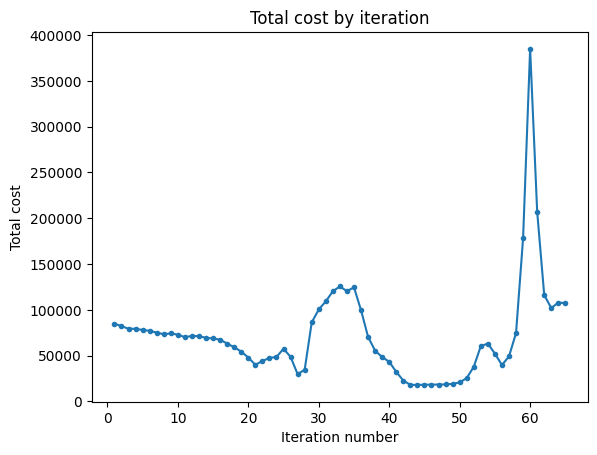

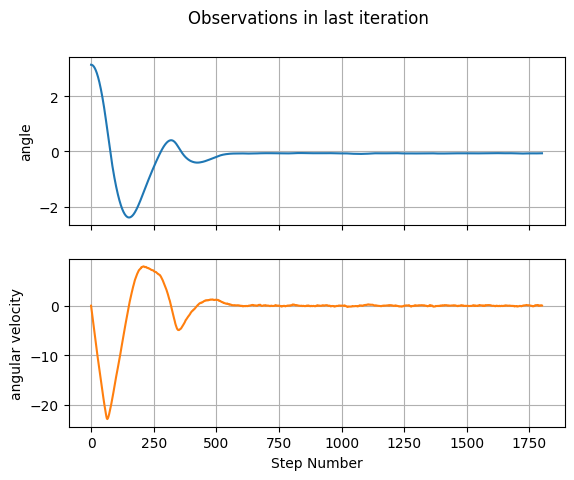

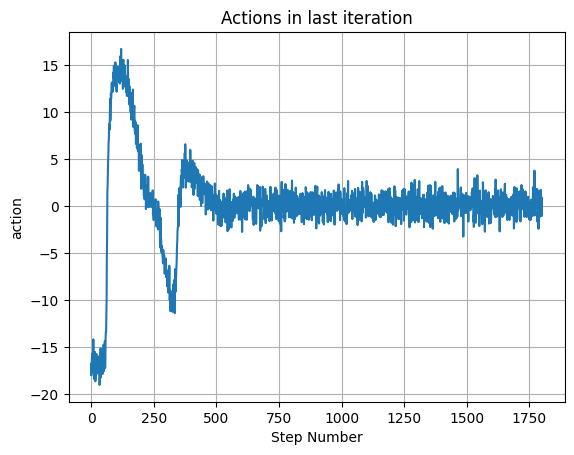

-----------------------------------------------------
Environment solved! Grade: 100%


In [15]:
SEED = 14
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

system = InvertedPendulumSystem()
## DO NOT CHANGE THE PARAMS OF SIMULATOR.
simulator = Simulator(
    system, N_steps=1800, step_size=0.003, state_init=np.array([np.pi, 0.0])
)
discount_factor = 0.999  # do not change this

model = GaussianPDFModel(
    dim_observation=system.dim_observation,
    dim_action=system.dim_action,
    action_bounds=np.array([[-20, 20]]),
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    n_hidden_layers=2,  # TRY TO FIND n_hidden_layers EMPIRICALLY
    scale_factor=50,  # TRY TO FIND scale_factor EMPIRICALLY
    dim_hidden=4,  # TRY TO FIND dim_hidden EMPIRICALLY
    std=0.05,  # TRY TO FIND STD EMPIRICALLY
    # ---------------------------------------------------------------------------
)
critic_model = ModelPerceptron(
    dim_input=system.dim_observation,
    dim_output=1,
    # --------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    dim_hidden=8, # TRY TO FIND dim_hidden EMPIRICALLY
    n_hidden_layers=3, # TRY TO FIND n_hidden_layers EMPIRICALLY
    # --------------------------------------------------------------------------
)

critic_optimizer = Optimizer(
    model=critic_model,
    opt_method=torch.optim.Adam,
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=0.05), # TRY TO FIND lr EMPIRICALLY
    n_epochs=10, # TRY TO FIND n_epochs EMPIRICALLY
    # ---------------------------------------------------------------------------
    is_reinstantiate_optimizer=True,  # we reinstantiate optimizer before every
    # optimization procedure to guarantee
    # that Adam doesn't remeber previous gradients
)

critic = Critic(
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    td_n=10, # TRY TO FIND td_n EMPIRICALLY
    # ---------------------------------------------------------------------------
    discount_factor=discount_factor,
    device="cpu",
    model=critic_model,
    optimizer=critic_optimizer,
)


policy_optimizer = Optimizer(
    model=model,
    opt_method=torch.optim.Adam,
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    opt_options=dict(lr=0.05),  # TRY TO FIND lr EMPIRICALLY
    # ---------------------------------------------------------------------------
    is_reinstantiate_optimizer=False,
)
## Or if you want to use scheduler then initialize optimizer, via, for instance
# lr_scheduler_fading_coeff = 1
# optimizer = Optimizer(
#     model=model,
#     opt_method=torch.optim.Adam,
#     opt_options=dict(lr=1.0, betas=(0.8, 0.9)),
#     shuffle=False,
#     lr_scheduler_method=torch.optim.lr_scheduler.MultiplicativeLR,
#     lr_scheduler_options={
#         "lr_lambda": lambda iteration: 1
#         / np.sqrt((iteration / lr_scheduler_fading_coeff) ** 2 + 1)
#     },
#     lr_scheduler_switch=LRSchedulerSwitch(norm_observation_threshold=0.1),
# )
#
# BELEIVE US! YOU CAN SOLVE THIS TASK WITHOUT SCHEDULER

policy = Policy(
    model,
    policy_optimizer,
    critic=critic,
    discount_factor=discount_factor,
)


# This termination criterion never terminates episodes
trivial_terminantion_criterion = lambda *args: False

## EXAMPLE. This termination criterion terminates episode if observation norm >= 20
#
# termination_criterion = (
#     lambda observation, action, running_cost, total_cost: (
#         np.linalg.norm(observation) >= 20
#     )
# )
#
# DO NOT USE TERMINATION CRITERION OTHER THAN trivial_termination_criterion


scenario = MonteCarloSimulationScenario(
    simulator=simulator,
    system=system,
    policy=policy,
    critic=critic,
    # ---------------------------------------------------------------------------
    # YOUR CODE GOES HERE
    N_episodes=2,  # Increasing the number of episodes stabilizes learning
    N_iterations=65,  # You can change the number of iterations if you want
    # ---------------------------------------------------------------------------
    termination_criterion=trivial_terminantion_criterion,
    discount_factor=discount_factor,
)

try:
    scenario.run()
except KeyboardInterrupt:
    clear_output(wait=True)
    scenario.plot_data()

clear_output(wait=True)
scenario.plot_data()

# Theory behind REINFORCE and Actor-Critic Policy Gradient

## Notation


From now on we will use the following notation:

| Notation &nbsp; &nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;&nbsp; Description |
|:-----------------------:|-------------|
| $f(\cdot, \cdot, \cdot) : \R^{n+1}\times \R^{m} \ra \R^{n}$ |**state dynamic (or transition) function** which may refer to the right-hand side of a difference equation $x_{k+1} = f(k, x_k, u_k)$ or differential equation $\dot{x} = f(t, x, u)$ or a probability distribution $X_{k+1} \sim f(x_{k+1} \mid k, x_k, u_k)$
| $x \in \R^{n} $ | **State** |
| $u \in \R^{m}$ | **Action** |
| $y \in \R^{l}$ | **Observartion**|
| $\X \subseteq \R^{n} $| **State space**|
| $\U \subseteq \R^{m} $| **Action space**|
| $\Y \subseteq \R^{l} $| **Observation space**|
| $h(\cdot): \R^{n} \ra \R^{l}$ | **Observation function** that maps states $x$ to observation $y$, i.e., $y = h(x)$ |
| $\rho^{\theta}(\cdot \mid \cdot ) : \R^{m} \times \R^{l} \ra \R$ | **Policy** model (in general as a distribution) with weights $\theta$ |
| $r(\cdot, \cdot) : \R^{n} \times \R^{m} \ra \R$ | **running cost** function  |
| $[Z]_{k:k'}$ | finite sequence $\{Z_k, Z_{k+1}, ..., Z_{k'-1}\}$|
| $[Z]_{k:\infty}$ | infinite sequence $\{Z_k, Z_{k+1}, ... \}$|

In case of inverted pendulum, say, $n = m = 2$, $l = 1$ and
$$
\begin{aligned}
  x & =  \left(\begin{array}{l} \vartheta \\ \omega \end{array}\right), \\
  h(x) & = x, \\
  f(t, x, u) & = \left(\begin{array}{l} \omega \\ \frac{g}{l} \sin(\vartheta) + \frac{u}{m l^2} \end{array}\right), u \in [u_{\min}, u_{\max}].
\end{aligned}
$$

We take the running cost in quadratic form:
$$
    r(\vartheta, \omega, u) = 10 \vartheta^ 2 + 3 \omega ^ 2.
$$


The policy model will be taken as:
$$
\rho^{\theta}(u \mid \vartheta, \omega) = \mathsf{pdf}_{\mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu^{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)
$$

where $ \mathsf{pdf}_{\mathcal{N}(\bullet_1, \bullet_2)} $ refers to the normal probability density with mean $\bullet_1$ and (co)variance $\bullet_2$, $\beta = \frac{u_{\min} + u_{\max}}{2}$, $\lambda = \frac{u_{\max} - u_{\min}}{2}$ and
the $\mu^{\theta}(\cdot)$ is a perceptron with weights $\theta$:
$$
    \mu^{\theta}(y) : y \ra \text{Linear(2, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 4)} \ra \text{LeakyReLU(0.2)} \ra \text{Linear(4, 1)} \ra (1 - 3\sigma) \tanh\left(\frac{\cdot}{L}\right)
$$
##### Remarks
 - Hyperparameter $L$ is merely a tuning parameter and does not posess a physical meaning
 - Note that on every step $u$ is a random variable that is distributed as $u \sim \lambda \mathcal{N}(\mu^{\theta}(y), \sigma^2) + \beta = \mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)$
 - The fact that $\mathsf{pdf}_{\mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)}(u) = \mathsf{pdf}_{\mathcal{N}\left(\mu^{\theta}(y), \sigma^2\right)}\left(\frac{u - \beta}{\lambda}\right)$ is true due to $\lambda \mathcal{N}(\mu^{\theta}(y), \sigma^2) + \beta = \mathcal{N}\left(\lambda \mu^{\theta}(y) + \beta, \lambda^2\sigma^2\right)$
 - Note that $\frac{u - \beta}{\lambda} \in [-1, 1]$ for $u \in [u_{\min}, u_{\max}]$. By construction $\mu^{\theta}(y) \in [-1 + 3\sigma, 1 - 3\sigma]$. Thus, the policy $\rho^{\theta}(u \mid \vartheta, \omega)$ samples actions that are within action bounds $[u_{\min}, u_{\max}]$ with propability greater than 99.86% by $3\sigma$-[rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule). This slight imprecision has no effect on efficiency.

## Basics

Consider a system
$$
    X_{k + 1} \sim f(x_{k+1} \mid x_k, u_k), \quad Y_k = h(X_k), \quad U_{k} \sim \rho^{\theta}(u_{k} \mid y_k).
$$
If the observation function is trivial (an identity), we can just consider:
$$
    Y_{k+1} \sim f(y_{k+1} \mid y_k, u_k), \quad U_{k} \sim \rho^{\theta}(u_{k} \mid y_k).
$$
We will thus refer to $y$ as observation and state interchangeably since they are identical.

The goal is to solve the following optimal control problem
$$
    \min_{\theta} J_N(\theta) = \EP{f,\rho^\theta}{\sum_{k = 0}^{N-1} \gamma^k r(Y_k, U_k)}
$$
over policy weights $\theta$.
Here, $\gamma$ is the so called *discount factor*.
Notice we stress the probability distributions which generate randomness in the above formula under the expectation sign.
From now on, we will use a shorthand notation *pdf* to refer to a prbability distribution (function).

Let us introduce the following notation
$$
    Z:= (Y, U).
$$
Thus, we can now shorten the system description as follows:
$$
    Z_{k+1} \sim \tau^\theta(z_{k+1} \mid z_k),
$$
where $\tau^\theta$ is a pdf that packs $f, \rho^\theta$ inside it.

The process $\{Z_k\}_k$ can be interpreted as a state-action trajectory.

Let us introduce the following random variable
$$
    [Z]_{k:k'} := \{Z_k, Z_{k+1}, \dots, Z_{k'-1}\}.
$$

This is just stacking up several state-action pairs into one pack.

Consider now an accumulated $N$-horizon cost:
$$
    r\left([Z]_{0:N}\right) := \sum_{k=0}^{N-1} \gamma ^ k r(Z_k),
$$
It is also reasonable to introduce here the notation for $r\left([Z]_{k:N}\right)$:
$$
    r\left([Z]_{k:N}\right) := \sum_{k'=k}^{N-1} \gamma ^ {k'} r(Z_{k'}),
$$

Remember that the transition probability of $Z$ depends on $\theta$.
Thus,
$$
    J_N(\theta) = \EP{\tau^\theta}{r\left([Z]_{0:N}\right)}.
$$

Let us unwrap the $N$-step objective:
$$
    J_N(\theta) = \E{r\left([Z]_{0:N}\right)} =
    \int_{\Y^{N} \cdot \U^{N}} r\left([Z]_{0:N}\right) \tau^{\theta}\left([z]_{0:N}\right) \diff [z]_{0:N},
$$
where $\tau^{\theta}([z]_{0:N})$ is understood as the product pdf of all consecutive state-actions pairs, i.e,:

$$
\tau^{\theta}([z]_{0:N}) = f_0(y_0) \rho^\theta(u_0|y_0) \tau^\theta(z_1 | z_0) \cdot \dots,
$$

where $f_0$ is the pdf of the initial state.
Thus, we will somehat loosely treat $\tau^\theta$ as being a single transition pdf and a product pdf depending on the context.

One of the most straightforward ways to optimize the objective $J_N$ is to apply a gradient descent along $\theta$ as:
$$
    \theta_{i+1} \la \theta^i - \alpha_i \nabla_{\theta} J_N(\theta)\big|_{\theta = \theta^i},
$$
where $i$ is the gradient descent iteration index and $\alpha_i$ is the (generally iteration-dependent) learning rate.



## A look inside gradients

Now, we need to figure out the gradient $\nabla_{\theta} J_N(\theta)$, because in the current form it is not computationally tractable.
We will use the so called *log-likelihood trick* to this end, namely,:
$$
    \nabla_{\theta} \tau^{\theta}([z]_{0:N})
    =
    \frac{
        \nabla_{\theta} \tau^{\theta}\left([z]_{0:N}\right)
    }{
        \tau^{\theta}\left([z]_{0:N}\right)
    }
    \cdot \tau^{\theta}\left([z]_{0:N}\right)
    =
    \nabla_{\theta}\left(\ln \tau^{\theta}\left([z]_{0:N}\right)\right) \cdot \tau^{\theta}\left([z]_{0:N}\right).
$$
Thus,
$$
\begin{aligned}
    \nabla_{\theta} J_N(\theta) = \nabla_{\theta} \E{r\left([Z]_{0:N}\right)} = &
    \int_{\Y^{N} \times \U^{N}}
        r\left([z]_{0:N}\right) \nabla_{\theta} \tau^{\theta}\left([z]_{0:N}\right)
    \diff [z]_{0:N} = \\
    & \int_{\Y^{N} \times \U^{N}}
        r\left([z]_{0:N}\right) \nabla_{\theta}\left( \ln \tau^{\theta}\left([z]_{0:N}\right)\right)
        \cdot
        \tau^{\theta}\left([z]_{0:N}\right) \diff [z]_{0:N}.
\end{aligned}
$$
where
$$
    \nabla_{\theta}\left( \ln \tau^{\theta}\left([z]_{0:N}\right)\right)
    =
    \nabla_{\theta} \ln \left(
        f_0(y_0) \rho^{\theta}(u_0 \mid y_0)\prod_{k=0}^{N-2} \tau^\theta(z_{k+1} \mid z_k)
    \right)
    =
    \nabla_{\theta} \ln \left(
        f_0(y_0) \rho^{\theta}(u_0 \mid y_0) \prod_{k=0}^{N-2} f(y_{k+1} \mid y_k, u_k) \rho^{\theta}(u_{k+1} \mid y_{k+1})
    \right)
$$
which can be simplified to
$$
    % \nabla_{\theta}\left( \ln \tau^{\theta}\left([z]_{0:N}\right)\right)
    =
    \underbrace{
        \nabla_{\theta} \left( \ln f_0(y_0) +  \sum_{k = 0}^{N-2}\ln f(y_{k+1} \mid y_k, u_k)\right)
    }_{ = 0 \text{ due to independence of } \theta}
    +  
    \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(u_k \mid y_k)
    =
    \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(u_k \mid y_k).
$$
This leads us to the following representation of $\nabla_{\theta} J_N(\theta)$:
$$
    \nabla_{\theta} J_N(\theta)
    =
    \int_{\Y^{N} \times \U^{N}}
        r\left([z]_{0:N}\right) \nabla_{\theta}\left( \ln \tau^{\theta}\left([z]_{0:N}\right)\right)
        \cdot
        \tau^{\theta}\left([z]_{0:N}\right)
    \diff [z]_{0:N}
$$
which in turn equals to:
$$
    \int_{\Y^{N} \times \U^{N}}
        \left(r\left([z]_{0:N}\right) \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(u_k \mid y_k)\right)\cdot \tau^{\theta}\left([z]_{0:N}\right)
    \diff [z]_{0:N}.   
$$
Packing everything back inside the expectation, we get:
$$
  \nabla_{\theta} J_N(\theta)
    =
    \EP{\tau^\theta}{r\left([Z]_{0:N}\right) \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}.
$$

When we take thus computed gradient and plug into the gradient learning rule, we get the (vanilla) REINFORCE:
$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1}
    \la
    \theta^i
    -
    \alpha_i \E{r\left([Z]_{0:N}\right) \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)\big|_{\theta=\theta^i}}
    \\
    \hphantom{~}
    \end{array}
  }.
$$

In practice, $\E{\dots}$ is substituted for a sample mean and $N$ is either fixed or the episodes are run until success or failure.
Hence, a practical REINFORCE may read, assuming $M$ episodes per iteration:

$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1}
    \la
    \theta^i
    -
    \alpha_i \frac 1 M \sum_{j = 1}^M \left( \sum_{k=0}^{N-1} \gamma^k r(y^j_k, u^j_k) \sum_{k=0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(u^j_k \mid y^j_k)\big|_{\theta=\theta^i} \right)
    \\
    \hphantom{~}
    \end{array}
  },
$$
where $\bullet^j_k$ means a value at step $k$ in episode $j$.

REINFORCE manifests learning from pure experience without any use of the system model!

## Do not let the past distract you

Note that the accumulated cost $\sum_{k=0}^{N-1} \gamma^k r(Y_k, U_k)$ along a whole
trajectory, but it introduce some redundancy as the past costs do not matter to the agent.

Keeping this in mind let us do a few more simplifications to get rid of this redundancy.

Firstly, note that
$$
  \begin{aligned}
    & \E{r\left([Z]_{0:N}\right) \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} = \E{ \sum_{k = 0}^{N-1} \gamma^k r(Y_k, U_k) \sum_{k = 0}^{N-1} \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) } = \\
    & \E{\sum_{k = 0}^{N-1} \sum_{k'=0}^{N-1} \gamma^{k'} r(Y_{k'}, U_{k'})\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} =
    \sum_{k=0}^{N-1} \sum_{k' = 0}^{N-1}  \E{\gamma^{k'} r(Y_{k'}, U_{k'}) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}.
  \end{aligned}
$$
Let us apply the tower rule for $k' < k$:
$$
    \E{\gamma^{k'} r(Y_{k'}, U_{k'}) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
    =
    \E{\gamma^{k'} r(Y_{k'}, U_{k'})  \E{\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Y_{k'}, U_{k'}} }.
$$
Note that
$$
  Z_k \mid Z_{k'}=\left( y_{k'}, u_{k'} \right) \sim \rho^{\theta}(u_k \mid y_k) \int_{\Y^{k - k'-1} \times \U^{k - k' - 1}} f(y_k \mid z_{k-1}) \tau^\theta\left([z]_{{k'+1}:{k}}|(y_{k'}, u_{k'})\right) \diff [z]_{{k' + 1}:{k}}
$$
whence
$$
\begin{aligned}
    & \E{\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Y_{k'}=y_{k'}, U_{k'}=u_{k'}}
    = \\
    & \qquad \int_{\Y} \underbrace{\int_{\U}\nabla_{\theta}\left(\ln\rho^{\theta}(u_k \mid y_k)\right) \rho^{\theta}(u_k \mid y_k) \diff u_k}_{=\nabla_{\theta}(1) =\nabla_{\theta}(\text{const}) = 0}  \int_{\Y^{k - k' - 1} \times \U^{k - k' - 1}} f(y_k \mid z_{k-1}) \tau^\theta\left([z]_{{k'+1}:{k}}|(y_{k'}, u_{k'})\right) \diff [z]_{{k' + 1}:{k}} \diff y_k \\
    & \qquad = 0.
\end{aligned}
$$

This in turn means that:
$$
    \E{\sum_{k = 0}^{N-1} \sum_{k'=0}^{N-1} \gamma^{k'} r(Y_{k'}, U_{k'})\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
    =
    \E{ \sum_{k = 0}^{N-1} \sum_{k'=k}^{N-1} \gamma^{k'} r(Y_{k'}, U_{k'}) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
$$
$$
    =
    \E{ \sum_{k = 0}^{N-1} r\left([Z]_{k:N}\right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}.
$$

This leads to the following formulation of REINFORCE:
$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1} \la \theta_{i} - \alpha_i \E{  \sum_{k = 0}^{N-1} r\left([Z]_{k:N}\right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)\big|_{\theta=\theta^i}}
    \\
    \hphantom{~}
    \end{array}
  }.
$$

This principle is sometimes called **do not let the pass distruct you**.

<a name="baseline"></a>
## Baseline


Besides the discarding the past principle, we can reduce the variance of the gradient estimates by using baselines (cf. control variates) as follows:
$$
    \E{ \sum_{k = 0}^{N-1} r\left([Z]_{k:N}\right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
    =
    \E{ \sum_{k = 0}^{N-1} \left(r\left([Z]_{k:N}\right) - B_k\right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)},
$$
where for every $k$ a variable $B_k$ is introduced.
The baseline $B_k$ must be independent of $U_k$, conditioined on $Y_k$.
Or, a stronger, but simpler-to-check assumption may be used, namely, independence of $B_k$ on $U_k, Y_k$.

Let us examine the above equation.

If the stronger assumption holds, we have:

$$
\begin{aligned}
  & \E{B_k \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} =
  \E{B_k} \E{\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} = \\
  & \qquad \qquad \qquad \E{B_k} \underbrace{ \int_{\U}
        \nabla_\theta \left(\ln\rho^{\theta} (u_k | Y_k) \right) \cdot \rho^\theta(u_k | Y_k) \diff u_k}_{=\int_{\U} \nabla_\theta \rho^{\theta} (u_k | Y_k) \diff u_k=\nabla_{\theta} (1)=0}.
\end{aligned}  
$$

If the weaker assumption holds, we apply the tower rule:
$$
    \E{B_k \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
    =
    \E{\E{B_k \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Y_k}}.
$$
Using conditional independence of $B_k$ on $U_k$, we deduce:
$$
  \begin{aligned}
    & \E{\E{B_k \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Y_k}}
    = \\
    & \qquad \E{\E{B_k \mid Y_k} \E{\nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Y_k}}
  \end{aligned}
$$
which in turn equals
$$
    \E{\E{B_k \mid Y_k}  \underbrace{ \int_{\U}
        \nabla_\theta \left(\ln\rho^{\theta} (u_k | Y_k) \right) \cdot \rho^\theta(u_k | Y_k) \diff u_k
    }_{=\int_{\U}
        \nabla_\theta \rho^{\theta} (u_k | Y_k) \diff u_k=\nabla_{\theta} (1)=0}}
    = 0.
$$

Thus, we get **REINFORCE with baselines**:
$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1} \la \theta_{i} - \alpha_i \E{  \sum_{k = 0}^{N-1} \left( r\left([Z]_{k:N}\right) - B_k \right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)\big|_{\theta=\theta^i}}
    \\
    \hphantom{~}
    \end{array}
  }.
$$

**Remark**

Note that all inference above is valid for vanilla REINFOCE, i. e. one can perform REINFORCE in the following format:
$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1} \la \theta_{i} - \alpha_i \E{  \sum_{k = 0}^{N-1} \left( r\left([Z]_{0:N}\right) - B_k \right) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)\big|_{\theta=\theta^i}}
    \\
    \hphantom{~}
    \end{array}
  }.
$$

## Infinite horizon problem
Let us reformulate the optimal control problem from scratch for infinite horizon case.

Consider a system
$$
    X_{k + 1} \sim f(x_{k+1} \mid x_k, u_k), \quad Y_k = h(X_k), \quad U_{k} \sim \rho^{\theta}(u_{k} \mid y_k).
$$
If the observation function is trivial (an identity), we can just consider:
$$
    Y_{k+1} \sim f(y_{k+1} \mid y_k, u_k), \quad U_{k} \sim \rho^{\theta}(u_{k} \mid y_k).
$$
We will thus refer to $y$ as observation and state interchangeably since they are identical.

The goal is to solve the following optimal control problem
$$
    \min_{\theta} J(\theta) = \EP{f,\rho^\theta}{\sum_{k = 0}^{\infty} \gamma^k r(Y_k, U_k)} = \EP{f,\rho^\theta}{r(\left[Z]_{0:\infty}\right)}
$$
over policy weights $\theta$.
Here, $\gamma$ is the *discount factor*. For simplicity of notation in further text we will denote $\E{\cdot} := \EP{f,\rho^\theta}{\cdot}$.

### Cost-to-go, $Q$-function, Advantage

Before we start solving the stated problem we need to make an overview of the main Reinforcement Learning concepts.

Let us consider
$$
 \E{\sum_{k = 0}^{\infty} \gamma^k r(Y_k, U_k)}.
$$

The algorithm of deriving $Z_{k+1}$ from $Z_k$ is strictly defined by inverted pendulum system and policy $\rho^{\theta}$, so the value of $\E{\sum_{k = 0}^{\infty} \gamma^k r(Y_k, U_k)}$ fully depends on the distribution $f_0$ of initial observation $Y_0$ which can be arbitrary.

#### Cost-to-go
Thus, it is reasonable to consider the following object, which is called **cost-to-go**:

$$
    J^{\rho^{\theta}}(y) = \E{\sum_{k = 0}^{\infty} \gamma^k r(Y_k, U_k) \mid Y_0 = y}.
$$
In other words, $J^{\rho^{\theta}}(y)$ is the expected value of discounted sum of future costs with system being started from $y$. Moreover, the expected value $\E{J^{\rho^{\theta}}(Y_0)} = J(\theta)$. Indeed,

$$
    \E{J^{\rho^{\theta}}(Y_0)} = \E{\E{\sum_{k = 0}^{\infty} \gamma^k r(Y_k, U_k) | Y_0}} = \E{\sum_{k = 0}^{\infty} \gamma^k r(Y_k, U_k)} =
    \int_{\Y} J^{\rho^{\theta}}(y) f_0(y) dy.
$$

Let us also consider the following identity:

$$
    \E{J^{\rho^{\theta}}(Y_0)} =  \E{\sum_{k = 0}^{\infty} \gamma^k r(Y_k, U_k)} = \E{r(Y_0, U_0)}  + \gamma \E{\sum_{k = 0}^{\infty} \gamma^k r(Y_{k-1}, U_{k-1})}.
$$

Note that

$$
    \E{\sum_{k = 0}^{\infty} \gamma^k r(Y_{k-1}, U_{k-1})} = \E{\E{\sum_{k = 0}^{\infty} \gamma^k r(Y_{k-1}, U_{k-1}) \mid Y_1}} = \E{J^{\rho^{\theta}}(Y_1)}.
$$

So,

$$
    \E{J^{\rho^{\theta}}(Y_0)} =  \E{r(Y_0, U_0)}  + \gamma \E{J^{\rho^{\theta}}(Y_1)}.
$$

The identity is true not only for $Y_0$ and $Y_1$. It is also true for every pair of $Y_k$ and $Y_{k+1}$:

$$
    \E{J^{\rho^{\theta}}(Y_k)} =  \E{r(Y_k, U_k)}  + \gamma \E{J^{\rho^{\theta}}(Y_{k+1})}.
$$

The identity is sufficient condition for definition of $J^{\rho^{\theta}}$. In other words, if $J^{\rho^{\theta}}$ is the function that satisfies the identity then $J^{\rho^{\theta}}$ is cost-to-go. The intiution behind is straightforward. Via using the identity one can derive

$$
    \E{J^{\rho^{\theta}}(Y_0)} = \E{\sum_{k=0}^{N_{\text{TD}} - 1} \gamma ^ k r(Y_k, U_k)} + \gamma ^ {N_{\text{TD}}} \E{J^{\rho^{\theta}}(Y_{N_{\text{TD}}})}  
$$

So, $N_{\text{TD}} \ra \infty$ and you get the result.

**Approximating $J^{\rho^{\theta}}$: temporal difference Loss**

As we have already said the identity
$$
    \E{J^{\rho^{\theta}}(Y_k) - r(Y_k, U_k) - \gamma J^{\rho^{\theta}}(Y_{k + 1})} = 0  
$$
is sufficient for $J^{\rho^{\theta}}$ to be the cost-to-go. Thus, we can approximate $J^{\rho^{\theta}}$ with perceptorn $\hat{J}^{w}$
with weights $w$ via minimizing the following objective:
$$
    \sum_{k=0}^{N-2}(\hat{J}^{w}(y_k) - r(y_k, u_k) - \gamma \hat{J}^{w}(y_{k + 1}))^2 \ra \min_w,
$$
where $y_0, u_0, y_1, u_1, ..., y_{N-1}, u_{N-1}$ is the sampled episode trajectory. The objective
$$
    \frac{1}{N-2}\sum_{k=0}^{N-2}(\hat{J}^{w}(y_k) - r(y_k, u_k) - \gamma \hat{J}^{w}(y_{k + 1}))^2
$$
is called Temporal Difference loss. By following the same logic we can transform
$$
\E{J^{\rho^{\theta}}(Y_k) - r(Y_k, U_k) - \gamma r(Y_{k+1}, U_{k+1}) - \gamma ^ 2 r(Y_{k+2}, U_{k+2}) - ... - \gamma ^ {N_{\text{TD}} - 1} r(Y_{k+N_{\text{TD}} - 1}, U_{k+N_{\text{TD}} - 1}) -  \gamma ^ {N_{\text{TD}}} J^{\rho^{\theta}}(Y_{k + N_{\text{TD}}})} = 0
$$
to the following temporal difference loss in general form:
$$
\frac{\sum\limits_{k = 0}^{N-1-N_{\text{TD}}} \left(\hat{J}^{w}(y_k) -  r(y_k, u_k) - \gamma r(y_{k+1}, u_{k+1}) - ... - \gamma^{N_{\text{TD}}-1} r(y_{k + N_{\text{TD}}-1}, u_{k + N_{\text{TD}}-1}) - \gamma^{N_{\text{TD}}} \hat{J}^{w}(y_{k + N_{\text{TD}}})\right) ^ 2}{N-1-N_{\text{TD}}} \ra \min_w,
$$
which provides us better approximation for $J^{\rho^{\theta}}$. The optimization procedure can be solved via gradient descent optimization procedure.

#### $Q$-function

$Q$-function is defined as follows
$$
    Q^{\rho^{\theta}}(y, u) = \E{\sum_{k=0}^{\infty} \gamma ^ k r(Y_k, U_k) \mid Y_0 = y, U_0 = u}
$$
and can be interpreted as the expected value of total costs conditioned that the system starts from $y$ and makes action $u$ as initial action with further applying the policy $\rho^{\theta}$ for infinite number of steps. There is an identity, which connects $Q$-function and $J(\theta)$:

$$
\E{Q^{\rho^{\theta}}(Y_0, U_0)} = \E{\sum_{k=0}^{\infty}\gamma^k r(Y_k, U_k)} = J(\theta).
$$

Similar to previous section one can derive:

$$
\E{Q^{\rho^{\theta}}(Y_k, U_k)} = \E{r(Y_k, U_k)} + \gamma \E{Q^{\rho^{\theta}}(Y_{k + 1}, U_{k + 1})}.
$$

There is an identity that connects cost-to-go and $Q$-function:

$$
    \E{Q^{\rho^{\theta}}(Y_k, U_k)} = \E{r(Y_k, U_k)} + \gamma \E{J^{\rho^{\theta}}(Y_{k+1})}.
$$

**Approximating $Q^{\rho^{\theta}}$: temporal difference Loss**

General form is as follows

$$
\frac{\sum\limits_{k = 0}^{N-1-N_{\text{TD}}} \left(\hat{Q}^{w}(y_k, u_k) -  r(y_k, u_k) - \gamma r(y_{k+1}, u_{k+1}) - ... - \gamma^{N_{\text{TD}}-1} r(y_{k + N_{\text{TD}}-1}, u_{k + N_{\text{TD}}-1}) - \gamma^{N_{\text{TD}}} \hat{Q}^{w}(y_{k + N_{\text{TD}}}, u_{k + N_{\text{TD}}})\right) ^ 2}{N-1-N_{\text{TD}}} \ra \min_w,
$$
where $\hat{Q}^{w}$ is, for instance, a neural network with weights $w$. The optimization problem can be solved via using gradient descent algorithm.
#### Advantage

Advantage $A^{\rho^{\theta}}$ is defined as follows

$$
    A^{\rho^{\theta}}(y, u) = Q^{\rho^{\theta}}(y, u) - J^{\rho^{\theta}}(y)
$$

and can be interpreted as the impact of action $u$ being taken in current $y$.

### Infrerence for initinite horizon problem

Similar to finite case one can derive that
$$
    \nabla_{\theta} J(\theta) = \E{  \sum_{k = 0}^{\infty}  r\left([Z]_{k:\infty}\right)  \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}.
$$

Let us consider one term from the sum and apply tower rule to it

$$
    \E{r\left([Z]_{k:\infty}\right)  \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} =
    \E{\E{r\left([Z]_{k:\infty}\right)  \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) \mid Z_k}} =
    \E{\E{r\left([Z]_{k:\infty}\right)\mid Z_k}  \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k) }.
$$

The multiplier
$$
\E{r\left([Z]_{k:\infty}\right)\mid Z_k} = \gamma^k Q^{\rho^{\theta}}(Y_k, U_k)
$$

Thus,

$$
    \E{r\left([Z]_{k:\infty}\right)  \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} = \E{\gamma ^ k Q^{\rho^{\theta}}(Y_k, U_k) \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)},
$$
and
$$
    \nabla_{\theta} J(\theta) = \E{  \sum_{k = 0}^{\infty} \gamma^k Q^{\rho^{\theta}}(Y_k, U_k)  \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
$$
We can rewrite it via using advantage function. Indeed, $J^{\rho^{\theta}}(Y_k)$ and $Q^{\rho^{\theta}}(Y_k, U_k)$ are conditionally independent conditioned on $Y_k$, so we can use
$\gamma ^k V(Y_k)$ as the baseline as follows:

$$
    \nabla_{\theta} J(\theta) = \E{  \sum_{k = 0}^{\infty} \gamma^k (Q^{\rho^{\theta}}(Y_k, U_k) - J^{\rho^{\theta}}(Y_k))  \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)} =
    \E{  \sum_{k = 0}^{\infty} \gamma^k A^{\rho^{\theta}}(Y_k, U_k)  \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}.
$$

Note that $\nabla_{\theta} J(\theta)$ can be rewritten via using only $J^{\rho^{\theta}}$ (we are using the identity $\E{Q^{\rho^{\theta}}(Y_k, U_k)} = \E{r(Y_k, U_k) + \gamma J^{\rho^{\theta}}(Y_{k+1})}$ here):

$$
    \nabla_{\theta} J(\theta) = \E{  \sum_{k = 0}^{\infty} \gamma^k (r(Y_k, U_k) + \gamma  J^{\rho^{\theta}}(Y_{k+1}) - J^{\rho^{\theta}}(Y_k))  \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}.
$$

Thus, update rule for Actor-Critic Policy Gradient can be written as follows

$$
  \boxed{
    \begin{array}{l}
    \hphantom{~}
    \\
    \theta_{i+1} \la \theta_{i} - \alpha_i \E{  \sum_{k = 0}^{\infty} \gamma^k (r(Y_k, U_k) + \gamma  J^{\rho^{\theta}}(Y_{k+1}) - J^{\rho^{\theta}}(Y_k))  \nabla_{\theta} \ln\rho^{\theta}(U_k \mid Y_k)}
    \\
    \hphantom{~}
    \end{array}
  }.
$$

<a name="miscellaneousremarks"></a>
## Miscellaneous remarks

Common approach for optimizing $\hat{J}^{w}$ is as follows:

>
> Save initial weights of critic before start of gradient descent procedure: $w^{\text{init}} := w$
>
> **for** $e$ in $\{1, ..., N_{\text{epochs}}^{\text{Critic}} \}$:
>>**for** $j$ in $\{1, \dots, M\}$:
>
>>> $
    w^{new} \la w^{old} -  \eta \nabla_{w}\left[\frac{\sum\limits_{k = 0}^{N-1-N_{\text{TD}}} \left(\hat{J}^{w}\left(y^j_k\right) - r\left(y^j_k, u_k^j\right) - \gamma r\left(y^j_{k+1}, u_{k+1}^j\right) - ... - \gamma^{N_{\text{TD}}-1} r\left(y^j_{k + N_{\text{TD}}-1}, u^j_{k + N_{\text{TD}}-1}\right) - \gamma^{N_{\text{TD}}} \hat{J}^{w^{\text{init}}}\left(y^j_{k + N_{\text{TD}}}\right)\right) ^ 2}{N-1-N_{\text{TD}}}\right]\bigg|_{w = w^{old}}
$
>
Note that the key difference from our approach is that $\hat{J}^{w^{\text{init}}}(y_{k + N_{\text{TD}}})$ is interpeted as constant in the equation above, so the gradient $\nabla_w[\hat{J}^{w^{\text{init}}}(y_{k + N_{\text{TD}}})] = 0$. The problem converges now for any $\gamma \in [0, 1]$ (even for $\gamma = 1$).

On can also write similar procedure for $\hat{Q}^{w}$:
>
> Save initial weights of critic before start of gradient descent procedure: $w^{\text{init}} := w$
>
> **for** $e$ in $\{1, ..., N_{\text{epochs}}^{\text{Critic}} \}$:
>>**for** $j$ in $\{1, \dots, M\}$:
>
>>> $
    w^{new} \la w^{old} -  \eta \nabla_{w}\left[\frac{\sum\limits_{k = 0}^{N-1-N_{\text{TD}}} \left(\hat{Q}^{w}\left(y^j_k, u^j_k\right) - r\left(y^j_k, u_k^j\right) - \gamma r\left(y^j_{k+1}, u_{k+1}^j\right) -  ... - \gamma^{N_{\text{TD}}-1} r\left(y^j_{k + N_{\text{TD}}-1}, u^j_{k + N_{\text{TD}}-1}\right) - \gamma^{N_{\text{TD}}} \hat{Q}^{w^{\text{init}}}\left(y^j_{k + N_{\text{TD}}},u^j_{k + N_{\text{TD}}}\right)\right) ^ 2}{N-1-N_{\text{TD}}}\right]\bigg|_{w = w^{old}}
$
>